## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn 
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import pickle

In [2]:
trainData = pd.read_csv('data/train.csv')
testData = pd.read_csv('data/test.csv')
sampleSubmission = pd.read_csv('data/sample_submission.csv')

print("Train Data Shape:", trainData.shape)
print("Test Data Shape:", testData.shape)
print("Sample Submission Shape:", sampleSubmission.shape)

Train Data Shape: (80000, 31)
Test Data Shape: (20000, 30)
Sample Submission Shape: (20000, 2)


In [3]:
# Label datasets for later separation
trainData['is_train'] = 1
testData['is_train'] = 0
testData['Default 12 Flag'] = np.nan  # Placeholder for uniform structure

# Combine for uniform feature engineering
data = pd.concat([trainData, testData], axis=0)


### Deriving Extra Features from dataset

In [4]:

# Convert dates
data['Date of Birth'] = pd.to_datetime(data['Date of Birth'])
data['Application Date'] = pd.to_datetime(data['Application Date'])

# Derive Age
data['Age'] = (data['Application Date'] - data['Date of Birth']).dt.days // 365

data['is_weekend'] = data['Application Date'].dt.weekday.isin([5, 6]).astype(int)
data['Application_Month'] = data['Application Date'].dt.month

data.drop(columns=['Date of Birth', 'Application Date', 'Application Time', 'ID'], inplace=True)

# Derived Features
data['Debt_to_Income'] = data['Declared Amount of Unsecured Loans'] / (data['Total Annual Income'] + 1)
data['Loan_Count_per_Dependent'] = data['Number of Unsecured Loans'] / (1 + data['Number of Dependents'])
data['Rent_to_Income'] = data['Rent Burden Amount'] / (data['Total Annual Income'] + 1)
data['Loan_Amount_per_Income'] = data['Amount of Unsecured Loans'] / (data['Total Annual Income'] + 1)
data['Declared_Loan_Amount_Diff'] = abs(data['Declared Amount of Unsecured Loans'] - data['Amount of Unsecured Loans'])
data['Declared_Loan_Count_Diff'] = abs(data['Declared Number of Unsecured Loans'] - data['Number of Unsecured Loans'])
data['Desired_Credit_to_Income'] = data['Application Limit Amount(Desired)'] / (data['Total Annual Income'] + 1)
data['Employment_Tenure_to_Age'] = data['Duration of Employment at Company (Months)'] / (data['Age'] * 12 + 1)
data['Short_Residence_Flag'] = (data['Duration of Residence (Months)'] < 12).astype(int)
data['Short_Employment_Flag'] = (data['Duration of Employment at Company (Months)'] < 6).astype(int)
data['Children_to_Dependent_Ratio'] = data['Number of Dependent Children'] / (1 + data['Number of Dependents'])
data['Household_Size'] = data['Number of Dependents'] + 1
data['Living_Alone_Flag'] = ((data['Family Composition Type'] == 0) | (data['Living Arrangement Type'] == 0)).astype(int)
data['Gender_Marital_Combo'] = data['Gender'].astype(str) + "_" + data['Single/Married Status'].astype(str)
data['Income_per_Month_Employment'] = data['Total Annual Income'] / (data['Duration of Employment at Company (Months)'] + 1)
data['Insurance_Employment_Combo'] = data['Insurance Job Type'].astype(str) + "_" + data['Employment Status Type'].astype(str)
data['Company_Industry_Combo'] = data['Company Size Category'].astype(str) + "_" + data['Industry Type'].astype(str)



In [5]:
derived_features = [
    'Age',
    'is_weekend',
    'Application_Month',
    'Debt_to_Income',
    'Loan_Count_per_Dependent',
    'Rent_to_Income',
    'Loan_Amount_per_Income',
    'Declared_Loan_Amount_Diff',
    'Declared_Loan_Count_Diff',
    'Desired_Credit_to_Income',
    'Employment_Tenure_to_Age',
    'Short_Residence_Flag',
    'Short_Employment_Flag',
    'Children_to_Dependent_Ratio',
    'Household_Size',
    'Living_Alone_Flag',
    'Gender_Marital_Combo',
    'Income_per_Month_Employment',
    'Insurance_Employment_Combo',
    'Company_Industry_Combo'
]

In [6]:
# Re-separate train and test
trainData = data[data['is_train'] == 1].drop(columns=['is_train'])
testData = data[data['is_train'] == 0].drop(columns=['is_train', 'Default 12 Flag'])

# Optionally, inspect or save
print("Enhanced train shape:", trainData.shape)
print("Enhanced test shape:", testData.shape)

Enhanced train shape: (80000, 47)
Enhanced test shape: (20000, 46)


In [7]:
print(trainData.columns)

Index(['Major Media Code', 'Internet Details', 'Reception Type Category',
       'Gender', 'Single/Married Status', 'Number of Dependents',
       'Number of Dependent Children', 'JIS Address Code', 'Residence Type',
       'Name Type', 'Rent Burden Amount', 'Duration of Residence (Months)',
       'Family Composition Type', 'Living Arrangement Type',
       'Insurance Job Type', 'Employment Type', 'Employment Status Type',
       'Industry Type', 'Company Size Category',
       'Duration of Employment at Company (Months)', 'Total Annual Income',
       'Declared Number of Unsecured Loans',
       'Declared Amount of Unsecured Loans', 'Number of Unsecured Loans',
       'Amount of Unsecured Loans', 'Application Limit Amount(Desired)',
       'Default 12 Flag', 'Age', 'is_weekend', 'Application_Month',
       'Debt_to_Income', 'Loan_Count_per_Dependent', 'Rent_to_Income',
       'Loan_Amount_per_Income', 'Declared_Loan_Amount_Diff',
       'Declared_Loan_Count_Diff', 'Desired_Credit_to_

In [8]:
# Check the number of values in column 'Default 12 flag' of train data with value 0
zero_count = (trainData['Default 12 Flag'] == 0).sum()
print("Number of values in 'Default 12 flag' column of train data with value 0:", zero_count)

# Check the number of values in 'Default 12 flag' column of train data with value 1
one_count = (trainData['Default 12 Flag'] == 1).sum()
print("Number of values in last column of train data with value 1:", one_count)

Number of values in 'Default 12 flag' column of train data with value 0: 72069
Number of values in last column of train data with value 1: 7931


In [9]:
data = trainData.copy()

In [10]:
num_cols = trainData.copy()
# remove ID and Default 12 Flag from num_cols
num_cols = num_cols.drop(['Default 12 Flag'], axis=1)
num_cols = num_cols.columns.tolist()

In [11]:
numericalCol = ['Declared Amount of Unsecured Loans', 'Number of Unsecured Loans', 'Number of Dependents', 'Number of Dependent Children', 'Rent Burden Amount', 'Duration of Residence (Months)', 'Duration of Employment at Company (Months)', 'Total Annual Income', 'Declared Number of Unsecured Loans' ,'Declared Amount of Unsecured Loans', 'Number of Unsecured Loans', 'Amount of Unsecured Loans', 'Application Limit Amount(Desired)', 'Age', 'Debt_to_Income', 'Loan_Count_per_Dependent', 'Rent_to_Income', 'Loan_Amount_per_Income', 'Declared_Loan_Amount_Diff', 'Declared_Loan_Count_Diff', 'Desired_Credit_to_Income', 'Employment_Tenure_to_Age', 'Children_to_Dependent_Ratio', 'Household_Size', 'Income_per_Month_Employment']
# normalise the numerical columns using StandardScaler 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data[numericalCol] = scaler.fit_transform(data[numericalCol])

print(data[numericalCol].head())

# print(len(numericalCol))

   Declared Amount of Unsecured Loans  Number of Unsecured Loans  \
0                           -0.000118                   0.878879   
1                           -0.015249                  -1.004147   
2                           -0.017410                  -1.004147   
3                           -0.014528                  -0.062634   
4                           -0.013087                  -1.004147   

   Number of Dependents  Number of Dependent Children  Rent Burden Amount  \
0             -0.549792                     -0.482562           -0.051327   
1              2.525429                      2.946351           -0.055762   
2              1.756624                     -0.482562           -0.048666   
3              3.294234                      2.946351           -0.051771   
4             -0.549792                     -0.482562           -0.042678   

   Duration of Residence (Months)  Duration of Employment at Company (Months)  \
0                       -0.781675              

In [12]:
categoricalCol = ['Major Media Code', 'Internet Details', 'Reception Type Category', 'Gender', 'Single/Married Status', 'Residence Type', 'Name Type', 'Family Composition Type', 'Living Arrangement Type', 'Insurance Job Type', 'Employment Type', 'Employment Status Type', 'Industry Type','Company Size Category', 'Short_Residence_Flag', 'Short_Employment_Flag', 'Living_Alone_Flag', 'Gender_Marital_Combo', 'Insurance_Employment_Combo', 'Company_Industry_Combo']

print(len(categoricalCol)+len(numericalCol))  # total number of features after adding 'Age' column
# 31 - Class - age - id

# the categorical columns need to be encoded using one hot encoding

# Create OneHotEncoder compatible with different sklearn versions (sparse vs sparse_output)
try:
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
except TypeError:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit-transform the categorical columns
encoded_cats = encoder.fit_transform(data[categoricalCol])
print("Encoded categorical shape:", encoded_cats.shape)

# Get feature names if available and attach back to dataframe
try:
    feature_names = encoder.get_feature_names_out(categoricalCol)
except Exception:
    feature_names = [f'ohe_{i}' for i in range(encoded_cats.shape[1])]

ohe_df = pd.DataFrame(encoded_cats, columns=feature_names, index=data.index)
data = pd.concat([data.drop(columns=categoricalCol), ohe_df], axis=1)
print('Data with OHE shape:', data.shape)
print(data.head())

# Save encoder for later use on test/validation
with open('ohe_encoder.pkl','wb') as f:
    pickle.dump(encoder, f)


45
Encoded categorical shape: (80000, 268)
Data with OHE shape: (80000, 295)
   Number of Dependents  Number of Dependent Children  JIS Address Code  \
0             -0.549792                     -0.482562           46201.0   
1              2.525429                      2.946351           45204.0   
2              1.756624                     -0.482562           45204.0   
3              3.294234                      2.946351           45201.0   
4             -0.549792                     -0.482562           45201.0   

   Rent Burden Amount  Duration of Residence (Months)  \
0           -0.051327                       -0.781675   
1           -0.055762                       -0.082070   
2           -0.048666                       -0.597568   
3           -0.051771                        0.050486   
4           -0.042678                       -0.089435   

   Duration of Employment at Company (Months)  Total Annual Income  \
0                                   -0.471743             1

In [13]:
# compute the correlation of each feature with the target column 'Default 12 Flag'

corr_matrix = data.corr()
print("Correlation matrix shape:", corr_matrix.shape)

# Display the correlation matrix
print(corr_matrix)


# correlations = data.corr()['Default 12 Flag'].sort_values()
# print("Top 5 features with highest positive correlation:")
# print(correlations)  # last 5 + target itself


Correlation matrix shape: (295, 295)
                                Number of Dependents  \
Number of Dependents                        1.000000   
Number of Dependent Children                0.855754   
JIS Address Code                            0.042211   
Rent Burden Amount                          0.008089   
Duration of Residence (Months)              0.010774   
...                                              ...   
Company_Industry_Combo_9_6                  0.003138   
Company_Industry_Combo_9_7                  0.001112   
Company_Industry_Combo_9_8                  0.007372   
Company_Industry_Combo_9_9                 -0.000120   
Company_Industry_Combo_9_99                 0.005368   

                                Number of Dependent Children  \
Number of Dependents                                0.855754   
Number of Dependent Children                        1.000000   
JIS Address Code                                    0.052241   
Rent Burden Amount                

## Over-Sampling

In [14]:
# count number of class 1 
class_1_count = (data['Default 12 Flag'] == 1).sum()
print("Number of values in last column of train data with value 1:", class_1_count)

Number of values in last column of train data with value 1: 7931


In [15]:
import sklearn.cluster as cluster
import os
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers.regular import wgangp
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from ydata_synthetic.postprocessing.regular.inverse_preprocesser import inverse_transform

model = wgangp.model.WGAN_GP


In [16]:
class_1_data = data.loc[ data['Default 12 Flag']==1 ].copy()
print(class_1_data.shape)


# We define a K-means clustering method using sklearn, and declare that
# we want 2 clusters. We then apply this algorithm (fit_predict) to our train_data
# We essentially get an array of 7931 rows ('labels') having values either 0 or 1 for the 2 clustered classes.

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
num_cols = list(class_1_data.columns[ class_1_data.columns != 'Default 12 Flag' ])
labels = algorithm(*args, **kwds).fit_predict(class_1_data[num_cols])

# Get the count of both classes
print( pd.DataFrame( [ [sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

# Assign the k-means clustered classes' labels to the a seperate copy of train data 'fraud_w_classes'
fraud_w_classes = class_1_data.copy()
fraud_w_classes['Default 12 Flag'] = labels


(7931, 295)
   count
0   3563
1   4368


In [17]:
noise_dim = 293
dim = 128
batch_size = 128

log_step = 100
epochs = 500+1
learning_rate = 5e-4
beta_1 = 0.5
beta_2 = 0.9
models_dir = './cache'

#Setting the GAN model parameters and the training step parameters
gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           betas=(beta_1, beta_2),
                           noise_dim=noise_dim,
                           layers_dim=dim)

train_args = TrainParameters(epochs=epochs,
                             sample_interval=log_step)

In [18]:
from ydata_synthetic.synthesizers.regular import wgangp
help(wgangp.model.WGAN_GP)

Help on class WGAN_GP in module ydata_synthetic.synthesizers.regular.wgangp.model:

class WGAN_GP(ydata_synthetic.synthesizers.base.BaseGANModel)
 |  WGAN_GP(model_parameters, n_generator: int = 1, n_critic: int = 1, gradient_penalty_weight: int = 10)
 |  
 |  Method resolution order:
 |      WGAN_GP
 |      ydata_synthetic.synthesizers.base.BaseGANModel
 |      ydata_synthetic.synthesizers.base.BaseModel
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, model_parameters, n_generator: int = 1, n_critic: int = 1, gradient_penalty_weight: int = 10)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  c_lossfn(self, real)
 |      Compute critic loss.
 |      
 |      Args:
 |          real: real data
 |      
 |      Returns:
 |          critic loss
 |  
 |  define_gan(self, activation_info: Optional[NamedTuple] = None)
 |      Define the trainable model components.
 |      
 |      Args:
 |          activation_info (

In [19]:
synthesizer = model(gan_args,  n_critic=2)
# how can i get to know about the synthesizer.fit arguments

cat_cols = ['Default 12 Flag']
print(synthesizer.fit.__code__.co_varnames)
synthesizer.fit(data = fraud_w_classes, train_arguments = train_args, num_cols = num_cols, cat_cols = cat_cols)

('self', 'data', 'train_arguments', 'num_cols', 'cat_cols', 'processed_data', 'optimizers', 'iterations', 'train_summary_writer', 'epoch', '_', 'batch_data', 'cri_loss', 'ge_loss', 'model_checkpoint_base_name')


  0%|          | 1/501 [00:04<40:52,  4.90s/it]

Epoch: 0 | disc_loss: 4.7788023948669434e-05 | gen_loss: -0.016426948830485344


  0%|          | 2/501 [00:06<22:41,  2.73s/it]

Epoch: 1 | disc_loss: -0.11553386598825455 | gen_loss: -0.0027597977314144373


  1%|          | 3/501 [00:07<16:42,  2.01s/it]

Epoch: 2 | disc_loss: -0.10236740857362747 | gen_loss: 0.0013545143883675337


  1%|          | 4/501 [00:08<13:49,  1.67s/it]

Epoch: 3 | disc_loss: -0.11977428197860718 | gen_loss: -0.015291338786482811


  1%|          | 5/501 [00:09<12:10,  1.47s/it]

Epoch: 4 | disc_loss: -0.13182996213436127 | gen_loss: 0.021998103708028793


  1%|          | 6/501 [00:10<11:12,  1.36s/it]

Epoch: 5 | disc_loss: -0.14767876267433167 | gen_loss: 0.003141568275168538


  1%|▏         | 7/501 [00:11<10:41,  1.30s/it]

Epoch: 6 | disc_loss: -0.160053551197052 | gen_loss: 0.021066423505544662


  2%|▏         | 8/501 [00:12<10:15,  1.25s/it]

Epoch: 7 | disc_loss: -0.16821426153182983 | gen_loss: -0.0053042275831103325


  2%|▏         | 9/501 [00:14<09:58,  1.22s/it]

Epoch: 8 | disc_loss: -0.17605893313884735 | gen_loss: 0.016364600509405136


  2%|▏         | 10/501 [00:15<09:43,  1.19s/it]

Epoch: 9 | disc_loss: -0.1857079267501831 | gen_loss: -0.007539520505815744


  2%|▏         | 11/501 [00:16<09:38,  1.18s/it]

Epoch: 10 | disc_loss: -0.18327213823795319 | gen_loss: 0.0030746629927307367


  2%|▏         | 12/501 [00:17<09:30,  1.17s/it]

Epoch: 11 | disc_loss: -0.18916822969913483 | gen_loss: 0.010107297450304031


  3%|▎         | 13/501 [00:18<09:21,  1.15s/it]

Epoch: 12 | disc_loss: -0.18707172572612762 | gen_loss: 0.006862012669444084


  3%|▎         | 14/501 [00:19<09:27,  1.17s/it]

Epoch: 13 | disc_loss: -0.18137569725513458 | gen_loss: 0.0014801486395299435


  3%|▎         | 15/501 [00:21<09:31,  1.17s/it]

Epoch: 14 | disc_loss: -0.19688402116298676 | gen_loss: 0.009979693219065666


  3%|▎         | 16/501 [00:22<09:20,  1.16s/it]

Epoch: 15 | disc_loss: -0.17136085033416748 | gen_loss: 0.01094081811606884


  3%|▎         | 17/501 [00:23<09:15,  1.15s/it]

Epoch: 16 | disc_loss: -0.18251274526119232 | gen_loss: -0.017260123044252396


  4%|▎         | 18/501 [00:24<09:09,  1.14s/it]

Epoch: 17 | disc_loss: -0.18959924578666687 | gen_loss: -0.02325308695435524


  4%|▍         | 19/501 [00:25<09:00,  1.12s/it]

Epoch: 18 | disc_loss: -0.185789093375206 | gen_loss: -0.008003707975149155


  4%|▍         | 20/501 [00:26<08:50,  1.10s/it]

Epoch: 19 | disc_loss: -0.18042004108428955 | gen_loss: -0.01412494108080864


  4%|▍         | 21/501 [00:27<08:45,  1.10s/it]

Epoch: 20 | disc_loss: -0.1772913783788681 | gen_loss: -0.0063513643108308315


  4%|▍         | 22/501 [00:28<08:47,  1.10s/it]

Epoch: 21 | disc_loss: -0.18040205538272858 | gen_loss: -0.012228071689605713


  5%|▍         | 23/501 [00:29<08:50,  1.11s/it]

Epoch: 22 | disc_loss: -0.1897870898246765 | gen_loss: -0.00506055261939764


  5%|▍         | 24/501 [00:30<08:47,  1.11s/it]

Epoch: 23 | disc_loss: -0.18663236498832703 | gen_loss: -0.010136276483535767


  5%|▍         | 25/501 [00:32<08:41,  1.10s/it]

Epoch: 24 | disc_loss: -0.18483082950115204 | gen_loss: -0.022318249568343163


  5%|▌         | 26/501 [00:33<08:40,  1.10s/it]

Epoch: 25 | disc_loss: -0.18272095918655396 | gen_loss: -0.012432930991053581


  5%|▌         | 27/501 [00:34<08:38,  1.09s/it]

Epoch: 26 | disc_loss: -0.1842372566461563 | gen_loss: -0.03191525489091873


  6%|▌         | 28/501 [00:35<08:33,  1.09s/it]

Epoch: 27 | disc_loss: -0.17766344547271729 | gen_loss: -0.030357498675584793


  6%|▌         | 29/501 [00:36<08:32,  1.09s/it]

Epoch: 28 | disc_loss: -0.15994521975517273 | gen_loss: -0.025781534612178802


  6%|▌         | 30/501 [00:37<08:30,  1.08s/it]

Epoch: 29 | disc_loss: -0.15945219993591309 | gen_loss: -0.020620232447981834


  6%|▌         | 31/501 [00:38<08:24,  1.07s/it]

Epoch: 30 | disc_loss: -0.1569145917892456 | gen_loss: -0.01564333401620388


  6%|▋         | 32/501 [00:39<08:19,  1.07s/it]

Epoch: 31 | disc_loss: -0.17246288061141968 | gen_loss: -0.031695276498794556


  7%|▋         | 33/501 [00:40<08:20,  1.07s/it]

Epoch: 32 | disc_loss: -0.17741116881370544 | gen_loss: -0.035334475338459015


  7%|▋         | 34/501 [00:41<08:20,  1.07s/it]

Epoch: 33 | disc_loss: -0.17827700078487396 | gen_loss: -0.028747564181685448


  7%|▋         | 35/501 [00:42<08:20,  1.07s/it]

Epoch: 34 | disc_loss: -0.15595848858356476 | gen_loss: -0.037360068410634995


  7%|▋         | 36/501 [00:43<08:19,  1.07s/it]

Epoch: 35 | disc_loss: -0.1604667603969574 | gen_loss: -0.01566043309867382


  7%|▋         | 37/501 [00:44<08:21,  1.08s/it]

Epoch: 36 | disc_loss: -0.1654110997915268 | gen_loss: -0.03505465015769005


  8%|▊         | 38/501 [00:46<08:18,  1.08s/it]

Epoch: 37 | disc_loss: -0.1667439341545105 | gen_loss: -0.03601866215467453


  8%|▊         | 39/501 [00:47<08:16,  1.08s/it]

Epoch: 38 | disc_loss: -0.17025581002235413 | gen_loss: -0.03622126951813698


  8%|▊         | 40/501 [00:48<08:16,  1.08s/it]

Epoch: 39 | disc_loss: -0.16327640414237976 | gen_loss: -0.02059607207775116


  8%|▊         | 41/501 [00:49<08:15,  1.08s/it]

Epoch: 40 | disc_loss: -0.13235972821712494 | gen_loss: -0.045149803161621094


  8%|▊         | 42/501 [00:50<08:18,  1.09s/it]

Epoch: 41 | disc_loss: -0.15419477224349976 | gen_loss: -0.03749140724539757


  9%|▊         | 43/501 [00:51<08:19,  1.09s/it]

Epoch: 42 | disc_loss: -0.13544271886348724 | gen_loss: -0.045392364263534546


  9%|▉         | 44/501 [00:52<08:24,  1.10s/it]

Epoch: 43 | disc_loss: -0.16160501539707184 | gen_loss: -0.036849137395620346


  9%|▉         | 45/501 [00:53<08:24,  1.11s/it]

Epoch: 44 | disc_loss: -0.16591578722000122 | gen_loss: -0.026533331722021103


  9%|▉         | 46/501 [00:54<08:22,  1.10s/it]

Epoch: 45 | disc_loss: -0.1235155314207077 | gen_loss: -0.046530935913324356


  9%|▉         | 47/501 [00:55<08:25,  1.11s/it]

Epoch: 46 | disc_loss: -0.1427706480026245 | gen_loss: -0.046681731939315796


 10%|▉         | 48/501 [00:57<08:25,  1.12s/it]

Epoch: 47 | disc_loss: -0.12586498260498047 | gen_loss: -0.04274265468120575


 10%|▉         | 49/501 [00:58<08:25,  1.12s/it]

Epoch: 48 | disc_loss: -0.16053709387779236 | gen_loss: -0.025134926661849022


 10%|▉         | 50/501 [00:59<08:29,  1.13s/it]

Epoch: 49 | disc_loss: -0.13481947779655457 | gen_loss: -0.04786977171897888


 10%|█         | 51/501 [01:00<08:30,  1.13s/it]

Epoch: 50 | disc_loss: -0.14604845643043518 | gen_loss: -0.044803448021411896


 10%|█         | 52/501 [01:01<08:31,  1.14s/it]

Epoch: 51 | disc_loss: -0.12318647652864456 | gen_loss: -0.02950204163789749


 11%|█         | 53/501 [01:02<08:31,  1.14s/it]

Epoch: 52 | disc_loss: -0.13328301906585693 | gen_loss: -0.029085742309689522


 11%|█         | 54/501 [01:03<08:31,  1.15s/it]

Epoch: 53 | disc_loss: -0.1375986784696579 | gen_loss: -0.04716801643371582


 11%|█         | 55/501 [01:05<08:37,  1.16s/it]

Epoch: 54 | disc_loss: -0.14952215552330017 | gen_loss: -0.04968160018324852


 11%|█         | 56/501 [01:06<08:41,  1.17s/it]

Epoch: 55 | disc_loss: -0.15180259943008423 | gen_loss: -0.04832075536251068


 11%|█▏        | 57/501 [01:07<08:40,  1.17s/it]

Epoch: 56 | disc_loss: -0.1495610624551773 | gen_loss: -0.04812168702483177


 12%|█▏        | 58/501 [01:08<08:39,  1.17s/it]

Epoch: 57 | disc_loss: -0.14760787785053253 | gen_loss: -0.04304349422454834


 12%|█▏        | 59/501 [01:09<08:35,  1.17s/it]

Epoch: 58 | disc_loss: -0.13876225054264069 | gen_loss: -0.03696640208363533


 12%|█▏        | 60/501 [01:11<08:36,  1.17s/it]

Epoch: 59 | disc_loss: -0.14350253343582153 | gen_loss: -0.04914547875523567


 12%|█▏        | 61/501 [01:12<08:24,  1.15s/it]

Epoch: 60 | disc_loss: -0.12396945804357529 | gen_loss: -0.05421527102589607


 12%|█▏        | 62/501 [01:13<08:16,  1.13s/it]

Epoch: 61 | disc_loss: -0.1272452175617218 | gen_loss: -0.051378339529037476


 13%|█▎        | 63/501 [01:14<08:17,  1.14s/it]

Epoch: 62 | disc_loss: -0.1356656402349472 | gen_loss: -0.035485509783029556


 13%|█▎        | 64/501 [01:15<08:15,  1.13s/it]

Epoch: 63 | disc_loss: -0.14389686286449432 | gen_loss: -0.05377141386270523


 13%|█▎        | 65/501 [01:16<08:17,  1.14s/it]

Epoch: 64 | disc_loss: -0.1396511197090149 | gen_loss: -0.057271040976047516


 13%|█▎        | 66/501 [01:17<08:21,  1.15s/it]

Epoch: 65 | disc_loss: -0.1264161467552185 | gen_loss: -0.07171455025672913


 13%|█▎        | 67/501 [01:18<08:19,  1.15s/it]

Epoch: 66 | disc_loss: -0.13730724155902863 | gen_loss: -0.05328455567359924


 14%|█▎        | 68/501 [01:20<08:11,  1.14s/it]

Epoch: 67 | disc_loss: -0.14314134418964386 | gen_loss: -0.055875249207019806


 14%|█▍        | 69/501 [01:21<08:03,  1.12s/it]

Epoch: 68 | disc_loss: -0.1300700306892395 | gen_loss: -0.06920616328716278


 14%|█▍        | 70/501 [01:22<07:59,  1.11s/it]

Epoch: 69 | disc_loss: -0.1396472007036209 | gen_loss: -0.04753801226615906


 14%|█▍        | 71/501 [01:23<07:57,  1.11s/it]

Epoch: 70 | disc_loss: -0.14409120380878448 | gen_loss: -0.049805913120508194


 14%|█▍        | 72/501 [01:24<07:55,  1.11s/it]

Epoch: 71 | disc_loss: -0.1290467530488968 | gen_loss: -0.054196879267692566


 15%|█▍        | 73/501 [01:25<07:57,  1.12s/it]

Epoch: 72 | disc_loss: -0.1291174590587616 | gen_loss: -0.0494510643184185


 15%|█▍        | 74/501 [01:26<07:54,  1.11s/it]

Epoch: 73 | disc_loss: -0.1380319893360138 | gen_loss: -0.05056873708963394


 15%|█▍        | 75/501 [01:27<08:03,  1.13s/it]

Epoch: 74 | disc_loss: -0.14098864793777466 | gen_loss: -0.0499008446931839


 15%|█▌        | 76/501 [01:29<08:03,  1.14s/it]

Epoch: 75 | disc_loss: -0.13710683584213257 | gen_loss: -0.04649387300014496


 15%|█▌        | 77/501 [01:30<08:00,  1.13s/it]

Epoch: 76 | disc_loss: -0.13731127977371216 | gen_loss: -0.07373873144388199


 16%|█▌        | 78/501 [01:31<07:56,  1.13s/it]

Epoch: 77 | disc_loss: -0.13634474575519562 | gen_loss: -0.05693189427256584


 16%|█▌        | 79/501 [01:32<07:53,  1.12s/it]

Epoch: 78 | disc_loss: -0.11980418860912323 | gen_loss: -0.06454651057720184


 16%|█▌        | 80/501 [01:33<07:52,  1.12s/it]

Epoch: 79 | disc_loss: -0.13555699586868286 | gen_loss: -0.06451558321714401


 16%|█▌        | 81/501 [01:34<07:57,  1.14s/it]

Epoch: 80 | disc_loss: -0.12813131511211395 | gen_loss: -0.06326326727867126


 16%|█▋        | 82/501 [01:35<07:53,  1.13s/it]

Epoch: 81 | disc_loss: -0.13942718505859375 | gen_loss: -0.050837334245443344


 17%|█▋        | 83/501 [01:36<07:49,  1.12s/it]

Epoch: 82 | disc_loss: -0.11211726814508438 | gen_loss: -0.051105424761772156


 17%|█▋        | 84/501 [01:38<07:59,  1.15s/it]

Epoch: 83 | disc_loss: -0.1264481097459793 | gen_loss: -0.06679028272628784


 17%|█▋        | 85/501 [01:39<07:55,  1.14s/it]

Epoch: 84 | disc_loss: -0.13980793952941895 | gen_loss: -0.06888503581285477


 17%|█▋        | 86/501 [01:40<07:55,  1.15s/it]

Epoch: 85 | disc_loss: -0.11978799849748611 | gen_loss: -0.05592690408229828


 17%|█▋        | 87/501 [01:41<07:48,  1.13s/it]

Epoch: 86 | disc_loss: -0.13460864126682281 | gen_loss: -0.054321061819791794


 18%|█▊        | 88/501 [01:42<07:45,  1.13s/it]

Epoch: 87 | disc_loss: -0.1255001574754715 | gen_loss: -0.07264535129070282


 18%|█▊        | 89/501 [01:43<07:46,  1.13s/it]

Epoch: 88 | disc_loss: -0.11394747346639633 | gen_loss: -0.0714600533246994


 18%|█▊        | 90/501 [01:44<07:45,  1.13s/it]

Epoch: 89 | disc_loss: -0.13267841935157776 | gen_loss: -0.06613466888666153


 18%|█▊        | 91/501 [01:46<07:46,  1.14s/it]

Epoch: 90 | disc_loss: -0.1310053914785385 | gen_loss: -0.062365271151065826


 18%|█▊        | 92/501 [01:47<07:58,  1.17s/it]

Epoch: 91 | disc_loss: -0.13216572999954224 | gen_loss: -0.05870651826262474


 19%|█▊        | 93/501 [01:48<07:52,  1.16s/it]

Epoch: 92 | disc_loss: -0.12259085476398468 | gen_loss: -0.0612364262342453


 19%|█▉        | 94/501 [01:49<07:52,  1.16s/it]

Epoch: 93 | disc_loss: -0.11093588173389435 | gen_loss: -0.07371365278959274


 19%|█▉        | 95/501 [01:50<07:45,  1.15s/it]

Epoch: 94 | disc_loss: -0.1294441521167755 | gen_loss: -0.05544961988925934


 19%|█▉        | 96/501 [01:51<07:39,  1.14s/it]

Epoch: 95 | disc_loss: -0.11323525756597519 | gen_loss: -0.06055667996406555


 19%|█▉        | 97/501 [01:52<07:37,  1.13s/it]

Epoch: 96 | disc_loss: -0.13703285157680511 | gen_loss: -0.05993926525115967


 20%|█▉        | 98/501 [01:54<07:40,  1.14s/it]

Epoch: 97 | disc_loss: -0.1289641559123993 | gen_loss: -0.05782623961567879


 20%|█▉        | 99/501 [01:55<07:39,  1.14s/it]

Epoch: 98 | disc_loss: -0.10608939826488495 | gen_loss: -0.0741044133901596


 20%|█▉        | 100/501 [01:56<07:44,  1.16s/it]

Epoch: 99 | disc_loss: -0.12520448863506317 | gen_loss: -0.072728231549263


 20%|██        | 101/501 [01:57<07:56,  1.19s/it]

Epoch: 100 | disc_loss: -0.13130037486553192 | gen_loss: -0.0656881183385849


 20%|██        | 102/501 [01:58<07:50,  1.18s/it]

Epoch: 101 | disc_loss: -0.10711806267499924 | gen_loss: -0.06941336393356323


 21%|██        | 103/501 [01:59<07:39,  1.15s/it]

Epoch: 102 | disc_loss: -0.11529696732759476 | gen_loss: -0.06657358258962631


 21%|██        | 104/501 [02:01<07:33,  1.14s/it]

Epoch: 103 | disc_loss: -0.11525510251522064 | gen_loss: -0.07299231737852097


 21%|██        | 105/501 [02:02<07:29,  1.13s/it]

Epoch: 104 | disc_loss: -0.11670873314142227 | gen_loss: -0.062807597219944


 21%|██        | 106/501 [02:03<07:24,  1.13s/it]

Epoch: 105 | disc_loss: -0.11889577656984329 | gen_loss: -0.07976389676332474


 21%|██▏       | 107/501 [02:04<07:21,  1.12s/it]

Epoch: 106 | disc_loss: -0.1338263601064682 | gen_loss: -0.08831660449504852


 22%|██▏       | 108/501 [02:05<07:19,  1.12s/it]

Epoch: 107 | disc_loss: -0.11537085473537445 | gen_loss: -0.07904313504695892


 22%|██▏       | 109/501 [02:06<07:16,  1.11s/it]

Epoch: 108 | disc_loss: -0.11783115565776825 | gen_loss: -0.08143274486064911


 22%|██▏       | 110/501 [02:07<07:14,  1.11s/it]

Epoch: 109 | disc_loss: -0.11446356028318405 | gen_loss: -0.07029223442077637


 22%|██▏       | 111/501 [02:08<07:12,  1.11s/it]

Epoch: 110 | disc_loss: -0.11553726345300674 | gen_loss: -0.07086053490638733


 22%|██▏       | 112/501 [02:09<07:08,  1.10s/it]

Epoch: 111 | disc_loss: -0.12022148072719574 | gen_loss: -0.06482832878828049


 23%|██▎       | 113/501 [02:10<07:05,  1.10s/it]

Epoch: 112 | disc_loss: -0.11351365596055984 | gen_loss: -0.08187270909547806


 23%|██▎       | 114/501 [02:12<07:05,  1.10s/it]

Epoch: 113 | disc_loss: -0.1273217499256134 | gen_loss: -0.08211161196231842


 23%|██▎       | 115/501 [02:13<07:03,  1.10s/it]

Epoch: 114 | disc_loss: -0.11803187429904938 | gen_loss: -0.07242228090763092


 23%|██▎       | 116/501 [02:14<07:01,  1.10s/it]

Epoch: 115 | disc_loss: -0.11831393092870712 | gen_loss: -0.08622806519269943


 23%|██▎       | 117/501 [02:15<07:04,  1.10s/it]

Epoch: 116 | disc_loss: -0.12181086838245392 | gen_loss: -0.08163147419691086


 24%|██▎       | 118/501 [02:16<07:02,  1.10s/it]

Epoch: 117 | disc_loss: -0.10392703115940094 | gen_loss: -0.07960108667612076


 24%|██▍       | 119/501 [02:17<07:13,  1.13s/it]

Epoch: 118 | disc_loss: -0.0544421449303627 | gen_loss: -0.07295627146959305


 24%|██▍       | 120/501 [02:18<07:14,  1.14s/it]

Epoch: 119 | disc_loss: -0.07596280425786972 | gen_loss: -0.06412739306688309


 24%|██▍       | 121/501 [02:19<07:12,  1.14s/it]

Epoch: 120 | disc_loss: -0.06542050093412399 | gen_loss: -0.0719178318977356


 24%|██▍       | 122/501 [02:21<07:09,  1.13s/it]

Epoch: 121 | disc_loss: -0.12251386791467667 | gen_loss: -0.08648008108139038


 25%|██▍       | 123/501 [02:22<07:08,  1.13s/it]

Epoch: 122 | disc_loss: -0.10713882744312286 | gen_loss: -0.07840791344642639


 25%|██▍       | 124/501 [02:23<07:14,  1.15s/it]

Epoch: 123 | disc_loss: -0.10779624432325363 | gen_loss: -0.05393531173467636


 25%|██▍       | 125/501 [02:24<07:10,  1.14s/it]

Epoch: 124 | disc_loss: -0.11798745393753052 | gen_loss: -0.08304551243782043


 25%|██▌       | 126/501 [02:25<07:06,  1.14s/it]

Epoch: 125 | disc_loss: -0.059412989765405655 | gen_loss: -0.09295263886451721


 25%|██▌       | 127/501 [02:26<07:01,  1.13s/it]

Epoch: 126 | disc_loss: -0.11263591796159744 | gen_loss: -0.07512091845273972


 26%|██▌       | 128/501 [02:27<06:59,  1.12s/it]

Epoch: 127 | disc_loss: -0.1203918308019638 | gen_loss: -0.07176091521978378


 26%|██▌       | 129/501 [02:29<06:58,  1.12s/it]

Epoch: 128 | disc_loss: -0.12200458347797394 | gen_loss: -0.0783553421497345


 26%|██▌       | 130/501 [02:30<06:57,  1.13s/it]

Epoch: 129 | disc_loss: -0.12114740163087845 | gen_loss: -0.07166193425655365


 26%|██▌       | 131/501 [02:31<07:03,  1.15s/it]

Epoch: 130 | disc_loss: -0.10260294377803802 | gen_loss: -0.07796666771173477


 26%|██▋       | 132/501 [02:32<07:01,  1.14s/it]

Epoch: 131 | disc_loss: -0.1161734014749527 | gen_loss: -0.07834787666797638


 27%|██▋       | 133/501 [02:33<06:53,  1.12s/it]

Epoch: 132 | disc_loss: -0.11299263685941696 | gen_loss: -0.07554761320352554


 27%|██▋       | 134/501 [02:34<06:49,  1.12s/it]

Epoch: 133 | disc_loss: -0.11086834967136383 | gen_loss: -0.09113144129514694


 27%|██▋       | 135/501 [02:35<06:46,  1.11s/it]

Epoch: 134 | disc_loss: -0.10417726635932922 | gen_loss: -0.08209598809480667


 27%|██▋       | 136/501 [02:36<06:41,  1.10s/it]

Epoch: 135 | disc_loss: -0.1036769226193428 | gen_loss: -0.08317585289478302


 27%|██▋       | 137/501 [02:37<06:38,  1.10s/it]

Epoch: 136 | disc_loss: -0.11293365061283112 | gen_loss: -0.08607734739780426


 28%|██▊       | 138/501 [02:38<06:34,  1.09s/it]

Epoch: 137 | disc_loss: -0.10643424093723297 | gen_loss: -0.07019295543432236


 28%|██▊       | 139/501 [02:40<06:36,  1.09s/it]

Epoch: 138 | disc_loss: -0.07160182297229767 | gen_loss: -0.08193570375442505


 28%|██▊       | 140/501 [02:41<06:35,  1.10s/it]

Epoch: 139 | disc_loss: -0.11755581945180893 | gen_loss: -0.07416581362485886


 28%|██▊       | 141/501 [02:42<06:35,  1.10s/it]

Epoch: 140 | disc_loss: -0.11683066934347153 | gen_loss: -0.07015509903430939


 28%|██▊       | 142/501 [02:43<06:32,  1.09s/it]

Epoch: 141 | disc_loss: -0.11267267912626266 | gen_loss: -0.07848402857780457


 29%|██▊       | 143/501 [02:44<06:32,  1.10s/it]

Epoch: 142 | disc_loss: -0.09533637017011642 | gen_loss: -0.07911361753940582


 29%|██▊       | 144/501 [02:45<06:30,  1.09s/it]

Epoch: 143 | disc_loss: -0.10765165090560913 | gen_loss: -0.07792667299509048


 29%|██▉       | 145/501 [02:46<06:31,  1.10s/it]

Epoch: 144 | disc_loss: -0.10572344064712524 | gen_loss: -0.07492624223232269


 29%|██▉       | 146/501 [02:47<06:29,  1.10s/it]

Epoch: 145 | disc_loss: -0.10315600782632828 | gen_loss: -0.07881646603345871


 29%|██▉       | 147/501 [02:48<06:27,  1.09s/it]

Epoch: 146 | disc_loss: -0.11255255341529846 | gen_loss: -0.08436015248298645


 30%|██▉       | 148/501 [02:49<06:27,  1.10s/it]

Epoch: 147 | disc_loss: -0.0577346533536911 | gen_loss: -0.07113803923130035


 30%|██▉       | 149/501 [02:51<06:27,  1.10s/it]

Epoch: 148 | disc_loss: -0.10349496454000473 | gen_loss: -0.09028761088848114


 30%|██▉       | 150/501 [02:52<06:24,  1.09s/it]

Epoch: 149 | disc_loss: -0.11704882979393005 | gen_loss: -0.08158233761787415


 30%|███       | 151/501 [02:53<06:21,  1.09s/it]

Epoch: 150 | disc_loss: -0.11330772936344147 | gen_loss: -0.06900140643119812


 30%|███       | 152/501 [02:54<06:19,  1.09s/it]

Epoch: 151 | disc_loss: -0.11230374127626419 | gen_loss: -0.07575255632400513


 31%|███       | 153/501 [02:55<06:20,  1.09s/it]

Epoch: 152 | disc_loss: -0.11230433732271194 | gen_loss: -0.07761858403682709


 31%|███       | 154/501 [02:56<06:46,  1.17s/it]

Epoch: 153 | disc_loss: -0.11502104252576828 | gen_loss: -0.08299224823713303


 31%|███       | 155/501 [02:57<06:45,  1.17s/it]

Epoch: 154 | disc_loss: -0.10625588148832321 | gen_loss: -0.07467305660247803


 31%|███       | 156/501 [02:59<06:52,  1.20s/it]

Epoch: 155 | disc_loss: -0.08507363498210907 | gen_loss: -0.08719441294670105


 31%|███▏      | 157/501 [03:00<07:01,  1.23s/it]

Epoch: 156 | disc_loss: -0.10755685716867447 | gen_loss: -0.09006573259830475


 32%|███▏      | 158/501 [03:01<06:58,  1.22s/it]

Epoch: 157 | disc_loss: -0.10167296975851059 | gen_loss: -0.09256458282470703


 32%|███▏      | 159/501 [03:02<06:59,  1.23s/it]

Epoch: 158 | disc_loss: -0.09141816943883896 | gen_loss: -0.06663797795772552


 32%|███▏      | 160/501 [03:04<07:00,  1.23s/it]

Epoch: 159 | disc_loss: -0.0870538279414177 | gen_loss: -0.08365137130022049


 32%|███▏      | 161/501 [03:05<07:05,  1.25s/it]

Epoch: 160 | disc_loss: -0.04011194407939911 | gen_loss: -0.09441562741994858


 32%|███▏      | 162/501 [03:06<07:02,  1.25s/it]

Epoch: 161 | disc_loss: -0.09380802512168884 | gen_loss: -0.08363083004951477


 33%|███▎      | 163/501 [03:07<06:58,  1.24s/it]

Epoch: 162 | disc_loss: -0.09873165190219879 | gen_loss: -0.0937633216381073


 33%|███▎      | 164/501 [03:09<06:54,  1.23s/it]

Epoch: 163 | disc_loss: -0.08067375421524048 | gen_loss: -0.0699211061000824


 33%|███▎      | 165/501 [03:10<06:45,  1.21s/it]

Epoch: 164 | disc_loss: -0.09974208474159241 | gen_loss: -0.07462555915117264


 33%|███▎      | 166/501 [03:11<06:33,  1.18s/it]

Epoch: 165 | disc_loss: -0.11010181158781052 | gen_loss: -0.09203074872493744


 33%|███▎      | 167/501 [03:12<06:24,  1.15s/it]

Epoch: 166 | disc_loss: -0.08341574668884277 | gen_loss: -0.07732028514146805


 34%|███▎      | 168/501 [03:13<06:17,  1.13s/it]

Epoch: 167 | disc_loss: -0.09263284504413605 | gen_loss: -0.08210829645395279


 34%|███▎      | 169/501 [03:14<06:11,  1.12s/it]

Epoch: 168 | disc_loss: -0.08965374529361725 | gen_loss: -0.07761181145906448


 34%|███▍      | 170/501 [03:15<06:09,  1.12s/it]

Epoch: 169 | disc_loss: -0.10445789992809296 | gen_loss: -0.08875448256731033


 34%|███▍      | 171/501 [03:16<06:05,  1.11s/it]

Epoch: 170 | disc_loss: -0.0778837725520134 | gen_loss: -0.07411819696426392


 34%|███▍      | 172/501 [03:17<06:00,  1.10s/it]

Epoch: 171 | disc_loss: -0.10498673468828201 | gen_loss: -0.08437986671924591


 35%|███▍      | 173/501 [03:19<06:03,  1.11s/it]

Epoch: 172 | disc_loss: -0.08498108386993408 | gen_loss: -0.09003318101167679


 35%|███▍      | 174/501 [03:20<06:05,  1.12s/it]

Epoch: 173 | disc_loss: -0.09927326440811157 | gen_loss: -0.07669174671173096


 35%|███▍      | 175/501 [03:21<06:10,  1.14s/it]

Epoch: 174 | disc_loss: -0.11209174245595932 | gen_loss: -0.08661779761314392


 35%|███▌      | 176/501 [03:22<06:06,  1.13s/it]

Epoch: 175 | disc_loss: -0.09064365923404694 | gen_loss: -0.0884014219045639


 35%|███▌      | 177/501 [03:23<06:05,  1.13s/it]

Epoch: 176 | disc_loss: -0.10700210928916931 | gen_loss: -0.10209323465824127


 36%|███▌      | 178/501 [03:24<06:00,  1.12s/it]

Epoch: 177 | disc_loss: -0.09774281829595566 | gen_loss: -0.08522732555866241


 36%|███▌      | 179/501 [03:25<05:55,  1.11s/it]

Epoch: 178 | disc_loss: -0.0895395502448082 | gen_loss: -0.07616496086120605


 36%|███▌      | 180/501 [03:26<05:52,  1.10s/it]

Epoch: 179 | disc_loss: -0.10135012120008469 | gen_loss: -0.07509942352771759


 36%|███▌      | 181/501 [03:27<05:48,  1.09s/it]

Epoch: 180 | disc_loss: -0.09834780544042587 | gen_loss: -0.09157007932662964


 36%|███▋      | 182/501 [03:29<05:49,  1.09s/it]

Epoch: 181 | disc_loss: -0.10618600249290466 | gen_loss: -0.07968541234731674


 37%|███▋      | 183/501 [03:30<05:51,  1.11s/it]

Epoch: 182 | disc_loss: -0.056013137102127075 | gen_loss: -0.08122240006923676


 37%|███▋      | 184/501 [03:31<05:54,  1.12s/it]

Epoch: 183 | disc_loss: -0.10742682963609695 | gen_loss: -0.0676257461309433


 37%|███▋      | 185/501 [03:32<05:50,  1.11s/it]

Epoch: 184 | disc_loss: -0.09397562593221664 | gen_loss: -0.0874127596616745


 37%|███▋      | 186/501 [03:33<05:48,  1.11s/it]

Epoch: 185 | disc_loss: -0.09189093112945557 | gen_loss: -0.07801884412765503


 37%|███▋      | 187/501 [03:34<05:42,  1.09s/it]

Epoch: 186 | disc_loss: -0.10398611426353455 | gen_loss: -0.08644082397222519


 38%|███▊      | 188/501 [03:35<05:39,  1.08s/it]

Epoch: 187 | disc_loss: -0.09720253944396973 | gen_loss: -0.08203476667404175


 38%|███▊      | 189/501 [03:36<05:37,  1.08s/it]

Epoch: 188 | disc_loss: -0.09644234925508499 | gen_loss: -0.08722180128097534


 38%|███▊      | 190/501 [03:37<05:35,  1.08s/it]

Epoch: 189 | disc_loss: -0.07849962264299393 | gen_loss: -0.08834129571914673


 38%|███▊      | 191/501 [03:38<05:32,  1.07s/it]

Epoch: 190 | disc_loss: -0.0645160973072052 | gen_loss: -0.09031391888856888


 38%|███▊      | 192/501 [03:39<05:29,  1.07s/it]

Epoch: 191 | disc_loss: -0.050914350897073746 | gen_loss: -0.07646116614341736


 39%|███▊      | 193/501 [03:41<05:29,  1.07s/it]

Epoch: 192 | disc_loss: -0.10173091292381287 | gen_loss: -0.09969387948513031


 39%|███▊      | 194/501 [03:42<05:28,  1.07s/it]

Epoch: 193 | disc_loss: -0.09469318389892578 | gen_loss: -0.08089558780193329


 39%|███▉      | 195/501 [03:43<05:26,  1.07s/it]

Epoch: 194 | disc_loss: -0.09980838000774384 | gen_loss: -0.08213116228580475


 39%|███▉      | 196/501 [03:44<05:23,  1.06s/it]

Epoch: 195 | disc_loss: -0.09382454305887222 | gen_loss: -0.08573319017887115


 39%|███▉      | 197/501 [03:45<05:22,  1.06s/it]

Epoch: 196 | disc_loss: -0.11294007301330566 | gen_loss: -0.08365339785814285


 40%|███▉      | 198/501 [03:46<05:21,  1.06s/it]

Epoch: 197 | disc_loss: -0.10293459892272949 | gen_loss: -0.09810269623994827


 40%|███▉      | 199/501 [03:47<05:19,  1.06s/it]

Epoch: 198 | disc_loss: -0.09887295961380005 | gen_loss: -0.09806276857852936


 40%|███▉      | 200/501 [03:48<05:18,  1.06s/it]

Epoch: 199 | disc_loss: -0.09943961352109909 | gen_loss: -0.08678745478391647


 40%|████      | 201/501 [03:49<05:22,  1.07s/it]

Epoch: 200 | disc_loss: -0.09132210910320282 | gen_loss: -0.06806853413581848


 40%|████      | 202/501 [03:50<05:26,  1.09s/it]

Epoch: 201 | disc_loss: -0.10499066859483719 | gen_loss: -0.07622013241052628


 41%|████      | 203/501 [03:51<05:24,  1.09s/it]

Epoch: 202 | disc_loss: -0.03139764070510864 | gen_loss: -0.09832984209060669


 41%|████      | 204/501 [03:52<05:21,  1.08s/it]

Epoch: 203 | disc_loss: -0.0988260805606842 | gen_loss: -0.09901677817106247


 41%|████      | 205/501 [03:53<05:18,  1.08s/it]

Epoch: 204 | disc_loss: -0.09540387988090515 | gen_loss: -0.105868861079216


 41%|████      | 206/501 [03:54<05:17,  1.08s/it]

Epoch: 205 | disc_loss: -0.09446197748184204 | gen_loss: -0.09951748698949814


 41%|████▏     | 207/501 [03:56<05:15,  1.07s/it]

Epoch: 206 | disc_loss: -0.09658076614141464 | gen_loss: -0.07559117674827576


 42%|████▏     | 208/501 [03:57<05:13,  1.07s/it]

Epoch: 207 | disc_loss: -0.08502079546451569 | gen_loss: -0.09148799628019333


 42%|████▏     | 209/501 [03:58<05:13,  1.07s/it]

Epoch: 208 | disc_loss: -0.09394707530736923 | gen_loss: -0.0785505622625351


 42%|████▏     | 210/501 [03:59<05:14,  1.08s/it]

Epoch: 209 | disc_loss: -0.08182431757450104 | gen_loss: -0.0951276421546936


 42%|████▏     | 211/501 [04:00<05:12,  1.08s/it]

Epoch: 210 | disc_loss: -0.09192236512899399 | gen_loss: -0.09376076608896255


 42%|████▏     | 212/501 [04:01<05:13,  1.08s/it]

Epoch: 211 | disc_loss: -0.1031750962138176 | gen_loss: -0.0886731743812561


 43%|████▎     | 213/501 [04:02<05:14,  1.09s/it]

Epoch: 212 | disc_loss: -0.03603871539235115 | gen_loss: -0.08575834333896637


 43%|████▎     | 214/501 [04:03<05:18,  1.11s/it]

Epoch: 213 | disc_loss: -0.08265378326177597 | gen_loss: -0.09110336750745773


 43%|████▎     | 215/501 [04:04<05:17,  1.11s/it]

Epoch: 214 | disc_loss: -0.10507319867610931 | gen_loss: -0.08650814741849899


 43%|████▎     | 216/501 [04:05<05:16,  1.11s/it]

Epoch: 215 | disc_loss: -0.087376669049263 | gen_loss: -0.08494856208562851


 43%|████▎     | 217/501 [04:07<05:15,  1.11s/it]

Epoch: 216 | disc_loss: -0.10648608952760696 | gen_loss: -0.08640634268522263


 44%|████▎     | 218/501 [04:08<05:12,  1.11s/it]

Epoch: 217 | disc_loss: -0.09265967458486557 | gen_loss: -0.0829542726278305


 44%|████▎     | 219/501 [04:09<05:08,  1.10s/it]

Epoch: 218 | disc_loss: -0.09777607023715973 | gen_loss: -0.09493385255336761


 44%|████▍     | 220/501 [04:10<05:06,  1.09s/it]

Epoch: 219 | disc_loss: -0.0991867333650589 | gen_loss: -0.0928146094083786


 44%|████▍     | 221/501 [04:11<05:05,  1.09s/it]

Epoch: 220 | disc_loss: -0.09841325134038925 | gen_loss: -0.09819772839546204


 44%|████▍     | 222/501 [04:12<05:04,  1.09s/it]

Epoch: 221 | disc_loss: -0.10602954775094986 | gen_loss: -0.088011734187603


 45%|████▍     | 223/501 [04:13<05:02,  1.09s/it]

Epoch: 222 | disc_loss: -0.0946212112903595 | gen_loss: -0.07810653001070023


 45%|████▍     | 224/501 [04:14<05:00,  1.09s/it]

Epoch: 223 | disc_loss: -0.10038386285305023 | gen_loss: -0.08883991092443466


 45%|████▍     | 225/501 [04:15<04:58,  1.08s/it]

Epoch: 224 | disc_loss: -0.09814286231994629 | gen_loss: -0.09254904091358185


 45%|████▌     | 226/501 [04:16<04:57,  1.08s/it]

Epoch: 225 | disc_loss: -0.09663963317871094 | gen_loss: -0.09578925371170044


 45%|████▌     | 227/501 [04:17<04:56,  1.08s/it]

Epoch: 226 | disc_loss: -0.09065748006105423 | gen_loss: -0.07893520593643188


 46%|████▌     | 228/501 [04:18<04:54,  1.08s/it]

Epoch: 227 | disc_loss: 0.04102121293544769 | gen_loss: -0.09152894467115402


 46%|████▌     | 229/501 [04:19<04:53,  1.08s/it]

Epoch: 228 | disc_loss: -0.029909968376159668 | gen_loss: -0.08551692217588425


 46%|████▌     | 230/501 [04:21<04:54,  1.09s/it]

Epoch: 229 | disc_loss: -0.08586703985929489 | gen_loss: -0.0806722342967987


 46%|████▌     | 231/501 [04:22<04:53,  1.09s/it]

Epoch: 230 | disc_loss: -0.08797969669103622 | gen_loss: -0.09224390983581543


 46%|████▋     | 232/501 [04:23<04:51,  1.08s/it]

Epoch: 231 | disc_loss: -0.0734691470861435 | gen_loss: -0.09880237281322479


 47%|████▋     | 233/501 [04:24<04:50,  1.08s/it]

Epoch: 232 | disc_loss: -0.014613784849643707 | gen_loss: -0.07225710153579712


 47%|████▋     | 234/501 [04:25<04:48,  1.08s/it]

Epoch: 233 | disc_loss: -0.09265843033790588 | gen_loss: -0.09185759723186493


 47%|████▋     | 235/501 [04:26<04:46,  1.08s/it]

Epoch: 234 | disc_loss: -0.07723169773817062 | gen_loss: -0.10168260335922241


 47%|████▋     | 236/501 [04:27<04:46,  1.08s/it]

Epoch: 235 | disc_loss: -0.1012708768248558 | gen_loss: -0.10061745345592499


 47%|████▋     | 237/501 [04:28<04:46,  1.09s/it]

Epoch: 236 | disc_loss: -0.036964498460292816 | gen_loss: -0.098253533244133


 48%|████▊     | 238/501 [04:29<04:45,  1.09s/it]

Epoch: 237 | disc_loss: -0.052602291107177734 | gen_loss: -0.08644981682300568


 48%|████▊     | 239/501 [04:30<04:44,  1.09s/it]

Epoch: 238 | disc_loss: -0.08215650916099548 | gen_loss: -0.08941546082496643


 48%|████▊     | 240/501 [04:31<04:43,  1.09s/it]

Epoch: 239 | disc_loss: -0.08916282653808594 | gen_loss: -0.10196918249130249


 48%|████▊     | 241/501 [04:33<04:43,  1.09s/it]

Epoch: 240 | disc_loss: -0.08240865916013718 | gen_loss: -0.08957063406705856


 48%|████▊     | 242/501 [04:34<04:41,  1.09s/it]

Epoch: 241 | disc_loss: -0.09586602449417114 | gen_loss: -0.09530027955770493


 49%|████▊     | 243/501 [04:35<04:41,  1.09s/it]

Epoch: 242 | disc_loss: -0.09775137156248093 | gen_loss: -0.09832483530044556


 49%|████▊     | 244/501 [04:36<04:40,  1.09s/it]

Epoch: 243 | disc_loss: -0.08590278029441833 | gen_loss: -0.09458057582378387


 49%|████▉     | 245/501 [04:37<04:38,  1.09s/it]

Epoch: 244 | disc_loss: -0.09574319422245026 | gen_loss: -0.10969977080821991


 49%|████▉     | 246/501 [04:38<04:36,  1.09s/it]

Epoch: 245 | disc_loss: -0.08953706920146942 | gen_loss: -0.09479182958602905


 49%|████▉     | 247/501 [04:39<04:34,  1.08s/it]

Epoch: 246 | disc_loss: -0.04533516615629196 | gen_loss: -0.08643978089094162


 50%|████▉     | 248/501 [04:40<04:33,  1.08s/it]

Epoch: 247 | disc_loss: -0.09434226900339127 | gen_loss: -0.09546953439712524


 50%|████▉     | 249/501 [04:41<04:33,  1.09s/it]

Epoch: 248 | disc_loss: -0.06076343357563019 | gen_loss: -0.09326308965682983


 50%|████▉     | 250/501 [04:42<04:32,  1.08s/it]

Epoch: 249 | disc_loss: -0.08132924139499664 | gen_loss: -0.09249933809041977


 50%|█████     | 251/501 [04:43<04:29,  1.08s/it]

Epoch: 250 | disc_loss: -0.06072288006544113 | gen_loss: -0.07734689861536026


 50%|█████     | 252/501 [04:44<04:28,  1.08s/it]

Epoch: 251 | disc_loss: -0.0913265198469162 | gen_loss: -0.10299080610275269


 50%|█████     | 253/501 [04:46<04:27,  1.08s/it]

Epoch: 252 | disc_loss: -0.08635496348142624 | gen_loss: -0.09282749146223068


 51%|█████     | 254/501 [04:47<04:26,  1.08s/it]

Epoch: 253 | disc_loss: -0.09572801738977432 | gen_loss: -0.09823569655418396


 51%|█████     | 255/501 [04:48<04:26,  1.09s/it]

Epoch: 254 | disc_loss: -0.08876334130764008 | gen_loss: -0.07939397543668747


 51%|█████     | 256/501 [04:49<04:24,  1.08s/it]

Epoch: 255 | disc_loss: -0.08566197007894516 | gen_loss: -0.09170926362276077


 51%|█████▏    | 257/501 [04:50<04:22,  1.08s/it]

Epoch: 256 | disc_loss: -0.09505582600831985 | gen_loss: -0.0841672271490097


 51%|█████▏    | 258/501 [04:51<04:22,  1.08s/it]

Epoch: 257 | disc_loss: -0.07430621981620789 | gen_loss: -0.08781932294368744


 52%|█████▏    | 259/501 [04:52<04:21,  1.08s/it]

Epoch: 258 | disc_loss: -0.08394875377416611 | gen_loss: -0.09654919803142548


 52%|█████▏    | 260/501 [04:53<04:20,  1.08s/it]

Epoch: 259 | disc_loss: -0.09010819345712662 | gen_loss: -0.08782774955034256


 52%|█████▏    | 261/501 [04:54<04:18,  1.08s/it]

Epoch: 260 | disc_loss: -0.09084474295377731 | gen_loss: -0.08866990357637405


 52%|█████▏    | 262/501 [04:55<04:17,  1.08s/it]

Epoch: 261 | disc_loss: -0.09568718820810318 | gen_loss: -0.09545323252677917


 52%|█████▏    | 263/501 [04:56<04:17,  1.08s/it]

Epoch: 262 | disc_loss: -0.08679106831550598 | gen_loss: -0.0783001184463501


 53%|█████▎    | 264/501 [04:57<04:16,  1.08s/it]

Epoch: 263 | disc_loss: -0.0744490697979927 | gen_loss: -0.08073394000530243


 53%|█████▎    | 265/501 [04:58<04:14,  1.08s/it]

Epoch: 264 | disc_loss: -0.05419708043336868 | gen_loss: -0.09265489131212234


 53%|█████▎    | 266/501 [05:00<04:13,  1.08s/it]

Epoch: 265 | disc_loss: -0.07237359136343002 | gen_loss: -0.08803355693817139


 53%|█████▎    | 267/501 [05:01<04:11,  1.08s/it]

Epoch: 266 | disc_loss: -0.0911114513874054 | gen_loss: -0.089567631483078


 53%|█████▎    | 268/501 [05:02<04:10,  1.07s/it]

Epoch: 267 | disc_loss: -0.029767293483018875 | gen_loss: -0.0863831639289856


 54%|█████▎    | 269/501 [05:03<04:09,  1.08s/it]

Epoch: 268 | disc_loss: -0.07667294889688492 | gen_loss: -0.11728335916996002


 54%|█████▍    | 270/501 [05:04<04:08,  1.07s/it]

Epoch: 269 | disc_loss: -0.06137130782008171 | gen_loss: -0.0984029769897461


 54%|█████▍    | 271/501 [05:05<04:06,  1.07s/it]

Epoch: 270 | disc_loss: -0.08145198971033096 | gen_loss: -0.07752451300621033


 54%|█████▍    | 272/501 [05:06<04:06,  1.08s/it]

Epoch: 271 | disc_loss: -0.09093714505434036 | gen_loss: -0.09715007245540619


 54%|█████▍    | 273/501 [05:07<04:06,  1.08s/it]

Epoch: 272 | disc_loss: -0.09720052778720856 | gen_loss: -0.08341702818870544


 55%|█████▍    | 274/501 [05:08<04:04,  1.08s/it]

Epoch: 273 | disc_loss: -0.07748344540596008 | gen_loss: -0.0768321081995964


 55%|█████▍    | 275/501 [05:09<04:02,  1.07s/it]

Epoch: 274 | disc_loss: -0.06761173903942108 | gen_loss: -0.09003525972366333


 55%|█████▌    | 276/501 [05:10<04:01,  1.07s/it]

Epoch: 275 | disc_loss: -0.08378870785236359 | gen_loss: -0.08063941448926926


 55%|█████▌    | 277/501 [05:11<04:00,  1.07s/it]

Epoch: 276 | disc_loss: -0.08779534697532654 | gen_loss: -0.09964185953140259


 55%|█████▌    | 278/501 [05:12<03:59,  1.07s/it]

Epoch: 277 | disc_loss: -0.09892034530639648 | gen_loss: -0.08789017796516418


 56%|█████▌    | 279/501 [05:14<04:01,  1.09s/it]

Epoch: 278 | disc_loss: -0.08720217645168304 | gen_loss: -0.08774008601903915


 56%|█████▌    | 280/501 [05:15<04:00,  1.09s/it]

Epoch: 279 | disc_loss: -0.06550529599189758 | gen_loss: -0.0905500054359436


 56%|█████▌    | 281/501 [05:16<04:01,  1.10s/it]

Epoch: 280 | disc_loss: -0.08299954235553741 | gen_loss: -0.1013699322938919


 56%|█████▋    | 282/501 [05:17<03:59,  1.09s/it]

Epoch: 281 | disc_loss: -0.08555779606103897 | gen_loss: -0.09344317018985748


 56%|█████▋    | 283/501 [05:18<03:59,  1.10s/it]

Epoch: 282 | disc_loss: -0.08717963844537735 | gen_loss: -0.09075086563825607


 57%|█████▋    | 284/501 [05:19<04:00,  1.11s/it]

Epoch: 283 | disc_loss: -0.0771142989397049 | gen_loss: -0.09445658326148987


 57%|█████▋    | 285/501 [05:20<04:01,  1.12s/it]

Epoch: 284 | disc_loss: -0.07570938766002655 | gen_loss: -0.07958120107650757


 57%|█████▋    | 286/501 [05:21<04:00,  1.12s/it]

Epoch: 285 | disc_loss: -0.07998958230018616 | gen_loss: -0.10260376334190369


 57%|█████▋    | 287/501 [05:22<03:58,  1.11s/it]

Epoch: 286 | disc_loss: -0.09132733941078186 | gen_loss: -0.08687122911214828


 57%|█████▋    | 288/501 [05:24<03:59,  1.12s/it]

Epoch: 287 | disc_loss: -0.0880516916513443 | gen_loss: -0.08380845189094543


 58%|█████▊    | 289/501 [05:25<03:58,  1.13s/it]

Epoch: 288 | disc_loss: -0.08825217187404633 | gen_loss: -0.10056862235069275


 58%|█████▊    | 290/501 [05:26<03:58,  1.13s/it]

Epoch: 289 | disc_loss: -0.028717584908008575 | gen_loss: -0.08968877047300339


 58%|█████▊    | 291/501 [05:27<03:56,  1.13s/it]

Epoch: 290 | disc_loss: -0.049261149019002914 | gen_loss: -0.08445991575717926


 58%|█████▊    | 292/501 [05:28<03:56,  1.13s/it]

Epoch: 291 | disc_loss: -0.0882992073893547 | gen_loss: -0.08959460258483887


 58%|█████▊    | 293/501 [05:29<03:55,  1.13s/it]

Epoch: 292 | disc_loss: -0.07631528377532959 | gen_loss: -0.09844013303518295


 59%|█████▊    | 294/501 [05:30<03:54,  1.13s/it]

Epoch: 293 | disc_loss: -0.07123272866010666 | gen_loss: -0.0724186822772026


 59%|█████▉    | 295/501 [05:32<03:55,  1.14s/it]

Epoch: 294 | disc_loss: -0.06640276312828064 | gen_loss: -0.10667768120765686


 59%|█████▉    | 296/501 [05:33<03:55,  1.15s/it]

Epoch: 295 | disc_loss: -0.09285227209329605 | gen_loss: -0.09221617877483368


 59%|█████▉    | 297/501 [05:34<03:54,  1.15s/it]

Epoch: 296 | disc_loss: -0.0724286437034607 | gen_loss: -0.09140725433826447


 59%|█████▉    | 298/501 [05:35<03:52,  1.14s/it]

Epoch: 297 | disc_loss: -0.08844532072544098 | gen_loss: -0.09531319886445999


 60%|█████▉    | 299/501 [05:36<03:50,  1.14s/it]

Epoch: 298 | disc_loss: -0.06201153248548508 | gen_loss: -0.09672541916370392


 60%|█████▉    | 300/501 [05:37<03:50,  1.15s/it]

Epoch: 299 | disc_loss: -0.07830442488193512 | gen_loss: -0.10045015811920166


 60%|██████    | 301/501 [05:39<03:52,  1.16s/it]

Epoch: 300 | disc_loss: -0.03932257369160652 | gen_loss: -0.10076893866062164


 60%|██████    | 302/501 [05:40<03:49,  1.15s/it]

Epoch: 301 | disc_loss: -0.053394485265016556 | gen_loss: -0.08243883401155472


 60%|██████    | 303/501 [05:41<03:45,  1.14s/it]

Epoch: 302 | disc_loss: -0.0664704218506813 | gen_loss: -0.09166491776704788


 61%|██████    | 304/501 [05:42<03:43,  1.14s/it]

Epoch: 303 | disc_loss: -0.07825001329183578 | gen_loss: -0.10202199220657349


 61%|██████    | 305/501 [05:43<03:42,  1.13s/it]

Epoch: 304 | disc_loss: -0.03861561417579651 | gen_loss: -0.08400489389896393


 61%|██████    | 306/501 [05:44<03:44,  1.15s/it]

Epoch: 305 | disc_loss: -0.06290058046579361 | gen_loss: -0.09531502425670624


 61%|██████▏   | 307/501 [05:45<03:39,  1.13s/it]

Epoch: 306 | disc_loss: -0.08236860483884811 | gen_loss: -0.08667467534542084


 61%|██████▏   | 308/501 [05:46<03:35,  1.12s/it]

Epoch: 307 | disc_loss: -0.08329658955335617 | gen_loss: -0.09160471707582474


 62%|██████▏   | 309/501 [05:47<03:32,  1.11s/it]

Epoch: 308 | disc_loss: -0.08312318474054337 | gen_loss: -0.08640703558921814


 62%|██████▏   | 310/501 [05:49<03:31,  1.11s/it]

Epoch: 309 | disc_loss: -0.05585254728794098 | gen_loss: -0.10565575212240219


 62%|██████▏   | 311/501 [05:50<03:29,  1.10s/it]

Epoch: 310 | disc_loss: -0.07818371057510376 | gen_loss: -0.08893097937107086


 62%|██████▏   | 312/501 [05:51<03:27,  1.10s/it]

Epoch: 311 | disc_loss: -0.01978006213903427 | gen_loss: -0.0890277698636055


 62%|██████▏   | 313/501 [05:52<03:26,  1.10s/it]

Epoch: 312 | disc_loss: -0.0718010812997818 | gen_loss: -0.09323041141033173


 63%|██████▎   | 314/501 [05:53<03:25,  1.10s/it]

Epoch: 313 | disc_loss: -0.07500721514225006 | gen_loss: -0.08130130171775818


 63%|██████▎   | 315/501 [05:54<03:23,  1.10s/it]

Epoch: 314 | disc_loss: -0.07800948619842529 | gen_loss: -0.09460803866386414


 63%|██████▎   | 316/501 [05:55<03:22,  1.09s/it]

Epoch: 315 | disc_loss: -0.07747828960418701 | gen_loss: -0.08033600449562073


 63%|██████▎   | 317/501 [05:56<03:19,  1.08s/it]

Epoch: 316 | disc_loss: -0.07215497642755508 | gen_loss: -0.09319235384464264


 63%|██████▎   | 318/501 [05:57<03:17,  1.08s/it]

Epoch: 317 | disc_loss: -0.059994712471961975 | gen_loss: -0.0954936295747757


 64%|██████▎   | 319/501 [05:58<03:15,  1.08s/it]

Epoch: 318 | disc_loss: -0.07978872209787369 | gen_loss: -0.0985533744096756


 64%|██████▍   | 320/501 [05:59<03:16,  1.09s/it]

Epoch: 319 | disc_loss: -0.08662965148687363 | gen_loss: -0.09296055138111115


 64%|██████▍   | 321/501 [06:01<03:19,  1.11s/it]

Epoch: 320 | disc_loss: -0.08317022025585175 | gen_loss: -0.1012897789478302


 64%|██████▍   | 322/501 [06:02<03:17,  1.11s/it]

Epoch: 321 | disc_loss: -0.05365859717130661 | gen_loss: -0.09563253819942474


 64%|██████▍   | 323/501 [06:03<03:17,  1.11s/it]

Epoch: 322 | disc_loss: -0.06669296324253082 | gen_loss: -0.08613904565572739


 65%|██████▍   | 324/501 [06:04<03:17,  1.11s/it]

Epoch: 323 | disc_loss: -0.06860949844121933 | gen_loss: -0.09452538192272186


 65%|██████▍   | 325/501 [06:05<03:15,  1.11s/it]

Epoch: 324 | disc_loss: -0.07871301472187042 | gen_loss: -0.10701153427362442


 65%|██████▌   | 326/501 [06:06<03:13,  1.11s/it]

Epoch: 325 | disc_loss: -0.05774473398923874 | gen_loss: -0.09133059531450272


 65%|██████▌   | 327/501 [06:07<03:10,  1.09s/it]

Epoch: 326 | disc_loss: -0.03212745487689972 | gen_loss: -0.09253374487161636


 65%|██████▌   | 328/501 [06:08<03:07,  1.08s/it]

Epoch: 327 | disc_loss: -0.06939747929573059 | gen_loss: -0.089896060526371


 66%|██████▌   | 329/501 [06:09<03:08,  1.10s/it]

Epoch: 328 | disc_loss: -0.07781961560249329 | gen_loss: -0.10236801952123642


 66%|██████▌   | 330/501 [06:10<03:05,  1.09s/it]

Epoch: 329 | disc_loss: -0.05062715709209442 | gen_loss: -0.09780772030353546


 66%|██████▌   | 331/501 [06:12<03:03,  1.08s/it]

Epoch: 330 | disc_loss: -0.05946454405784607 | gen_loss: -0.09521178901195526


 66%|██████▋   | 332/501 [06:13<03:01,  1.07s/it]

Epoch: 331 | disc_loss: -0.07185764610767365 | gen_loss: -0.0877237468957901


 66%|██████▋   | 333/501 [06:14<03:01,  1.08s/it]

Epoch: 332 | disc_loss: -0.08004548400640488 | gen_loss: -0.08625160157680511


 67%|██████▋   | 334/501 [06:15<03:02,  1.09s/it]

Epoch: 333 | disc_loss: -0.08220397680997849 | gen_loss: -0.10730086266994476


 67%|██████▋   | 335/501 [06:16<03:01,  1.10s/it]

Epoch: 334 | disc_loss: -0.048708681017160416 | gen_loss: -0.09046190232038498


 67%|██████▋   | 336/501 [06:17<03:00,  1.09s/it]

Epoch: 335 | disc_loss: -0.07983800023794174 | gen_loss: -0.10290245711803436


 67%|██████▋   | 337/501 [06:18<02:59,  1.09s/it]

Epoch: 336 | disc_loss: -0.025662142783403397 | gen_loss: -0.09145858883857727


 67%|██████▋   | 338/501 [06:19<02:57,  1.09s/it]

Epoch: 337 | disc_loss: -0.06577537208795547 | gen_loss: -0.08675228804349899


 68%|██████▊   | 339/501 [06:20<02:55,  1.08s/it]

Epoch: 338 | disc_loss: -0.07224172353744507 | gen_loss: -0.09928964078426361


 68%|██████▊   | 340/501 [06:21<02:54,  1.08s/it]

Epoch: 339 | disc_loss: -0.06624655425548553 | gen_loss: -0.08818963170051575


 68%|██████▊   | 341/501 [06:22<02:53,  1.08s/it]

Epoch: 340 | disc_loss: -0.06480728089809418 | gen_loss: -0.10330033302307129


 68%|██████▊   | 342/501 [06:23<02:52,  1.08s/it]

Epoch: 341 | disc_loss: -0.07719021290540695 | gen_loss: -0.09757453948259354


 68%|██████▊   | 343/501 [06:25<02:51,  1.09s/it]

Epoch: 342 | disc_loss: -0.05284379422664642 | gen_loss: -0.09292377531528473


 69%|██████▊   | 344/501 [06:26<02:53,  1.11s/it]

Epoch: 343 | disc_loss: -0.07388319820165634 | gen_loss: -0.09908583760261536


 69%|██████▉   | 345/501 [06:27<02:53,  1.11s/it]

Epoch: 344 | disc_loss: -0.07495372742414474 | gen_loss: -0.09960079193115234


 69%|██████▉   | 346/501 [06:28<02:54,  1.12s/it]

Epoch: 345 | disc_loss: -0.07048120349645615 | gen_loss: -0.10212081670761108


 69%|██████▉   | 347/501 [06:29<02:53,  1.13s/it]

Epoch: 346 | disc_loss: -0.06788527220487595 | gen_loss: -0.09319168329238892


 69%|██████▉   | 348/501 [06:30<02:52,  1.13s/it]

Epoch: 347 | disc_loss: -0.04412255063652992 | gen_loss: -0.08680685609579086


 70%|██████▉   | 349/501 [06:31<02:51,  1.13s/it]

Epoch: 348 | disc_loss: -0.04645295441150665 | gen_loss: -0.09600779414176941


 70%|██████▉   | 350/501 [06:33<02:50,  1.13s/it]

Epoch: 349 | disc_loss: -0.0064369142055511475 | gen_loss: -0.0972345769405365


 70%|███████   | 351/501 [06:34<02:51,  1.15s/it]

Epoch: 350 | disc_loss: -0.06694889813661575 | gen_loss: -0.09626071155071259


 70%|███████   | 352/501 [06:35<02:56,  1.19s/it]

Epoch: 351 | disc_loss: -0.0716991201043129 | gen_loss: -0.10901866853237152


 70%|███████   | 353/501 [06:36<02:57,  1.20s/it]

Epoch: 352 | disc_loss: -0.07476209849119186 | gen_loss: -0.11098453402519226


 71%|███████   | 354/501 [06:37<02:56,  1.20s/it]

Epoch: 353 | disc_loss: -0.07010315358638763 | gen_loss: -0.09597395360469818


 71%|███████   | 355/501 [06:39<02:53,  1.19s/it]

Epoch: 354 | disc_loss: -0.016033191233873367 | gen_loss: -0.10223067551851273


 71%|███████   | 356/501 [06:40<02:53,  1.20s/it]

Epoch: 355 | disc_loss: -0.04400961473584175 | gen_loss: -0.10346457362174988


 71%|███████▏  | 357/501 [06:41<02:50,  1.18s/it]

Epoch: 356 | disc_loss: -0.0751074030995369 | gen_loss: -0.08357538282871246


 71%|███████▏  | 358/501 [06:42<02:45,  1.16s/it]

Epoch: 357 | disc_loss: -0.07245746999979019 | gen_loss: -0.10354378819465637


 72%|███████▏  | 359/501 [06:43<02:43,  1.15s/it]

Epoch: 358 | disc_loss: -0.07122331112623215 | gen_loss: -0.0875973254442215


 72%|███████▏  | 360/501 [06:44<02:41,  1.14s/it]

Epoch: 359 | disc_loss: -0.07253345847129822 | gen_loss: -0.0987791195511818


 72%|███████▏  | 361/501 [06:45<02:37,  1.12s/it]

Epoch: 360 | disc_loss: -0.07646430283784866 | gen_loss: -0.09295940399169922


 72%|███████▏  | 362/501 [06:46<02:35,  1.12s/it]

Epoch: 361 | disc_loss: -0.046325311064720154 | gen_loss: -0.0931793600320816


 72%|███████▏  | 363/501 [06:48<02:33,  1.11s/it]

Epoch: 362 | disc_loss: -0.05916402116417885 | gen_loss: -0.10014458745718002


 73%|███████▎  | 364/501 [06:49<02:31,  1.11s/it]

Epoch: 363 | disc_loss: -0.06871159374713898 | gen_loss: -0.10022363811731339


 73%|███████▎  | 365/501 [06:50<02:30,  1.10s/it]

Epoch: 364 | disc_loss: -0.07898537814617157 | gen_loss: -0.09659434854984283


 73%|███████▎  | 366/501 [06:51<02:28,  1.10s/it]

Epoch: 365 | disc_loss: -0.06171288713812828 | gen_loss: -0.0901024341583252


 73%|███████▎  | 367/501 [06:52<02:26,  1.09s/it]

Epoch: 366 | disc_loss: -0.07217290997505188 | gen_loss: -0.091044582426548


 73%|███████▎  | 368/501 [06:53<02:25,  1.09s/it]

Epoch: 367 | disc_loss: -0.07996044307947159 | gen_loss: -0.10939422249794006


 74%|███████▎  | 369/501 [06:54<02:23,  1.09s/it]

Epoch: 368 | disc_loss: -0.0734468400478363 | gen_loss: -0.09395396709442139


 74%|███████▍  | 370/501 [06:55<02:23,  1.09s/it]

Epoch: 369 | disc_loss: -0.06685501337051392 | gen_loss: -0.09168939292430878


 74%|███████▍  | 371/501 [06:56<02:21,  1.09s/it]

Epoch: 370 | disc_loss: -0.07282788306474686 | gen_loss: -0.09761965274810791


 74%|███████▍  | 372/501 [06:57<02:21,  1.09s/it]

Epoch: 371 | disc_loss: -0.06849389523267746 | gen_loss: -0.0903065875172615


 74%|███████▍  | 373/501 [06:59<02:20,  1.10s/it]

Epoch: 372 | disc_loss: -0.06780681014060974 | gen_loss: -0.08335146307945251


 75%|███████▍  | 374/501 [07:00<02:20,  1.10s/it]

Epoch: 373 | disc_loss: -0.07257717847824097 | gen_loss: -0.0924978256225586


 75%|███████▍  | 375/501 [07:01<02:18,  1.10s/it]

Epoch: 374 | disc_loss: -0.06777714937925339 | gen_loss: -0.09677723795175552


 75%|███████▌  | 376/501 [07:02<02:17,  1.10s/it]

Epoch: 375 | disc_loss: -0.021465666592121124 | gen_loss: -0.09960097819566727


 75%|███████▌  | 377/501 [07:03<02:17,  1.11s/it]

Epoch: 376 | disc_loss: -0.06453351676464081 | gen_loss: -0.09263098239898682


 75%|███████▌  | 378/501 [07:04<02:16,  1.11s/it]

Epoch: 377 | disc_loss: -0.05158379301428795 | gen_loss: -0.08614559471607208


 76%|███████▌  | 379/501 [07:05<02:14,  1.10s/it]

Epoch: 378 | disc_loss: -0.06212200969457626 | gen_loss: -0.08942770957946777


 76%|███████▌  | 380/501 [07:06<02:12,  1.09s/it]

Epoch: 379 | disc_loss: -0.07216445356607437 | gen_loss: -0.102845698595047


 76%|███████▌  | 381/501 [07:07<02:10,  1.09s/it]

Epoch: 380 | disc_loss: -0.04273226857185364 | gen_loss: -0.10745091736316681


 76%|███████▌  | 382/501 [07:08<02:09,  1.09s/it]

Epoch: 381 | disc_loss: -0.061414144933223724 | gen_loss: -0.0864449068903923


 76%|███████▋  | 383/501 [07:09<02:08,  1.09s/it]

Epoch: 382 | disc_loss: -0.07385686039924622 | gen_loss: -0.09413796663284302


 77%|███████▋  | 384/501 [07:11<02:06,  1.08s/it]

Epoch: 383 | disc_loss: -0.061132192611694336 | gen_loss: -0.0967080146074295


 77%|███████▋  | 385/501 [07:12<02:05,  1.08s/it]

Epoch: 384 | disc_loss: -0.07036445289850235 | gen_loss: -0.0976969301700592


 77%|███████▋  | 386/501 [07:13<02:04,  1.08s/it]

Epoch: 385 | disc_loss: -0.07889269292354584 | gen_loss: -0.09432096034288406


 77%|███████▋  | 387/501 [07:14<02:03,  1.08s/it]

Epoch: 386 | disc_loss: -0.07134759426116943 | gen_loss: -0.09472248703241348


 77%|███████▋  | 388/501 [07:15<02:03,  1.09s/it]

Epoch: 387 | disc_loss: -0.07052400708198547 | gen_loss: -0.08992418646812439


 78%|███████▊  | 389/501 [07:16<02:02,  1.10s/it]

Epoch: 388 | disc_loss: -0.06166006997227669 | gen_loss: -0.10721327364444733


 78%|███████▊  | 390/501 [07:17<02:01,  1.09s/it]

Epoch: 389 | disc_loss: 0.011130273342132568 | gen_loss: -0.09691920876502991


 78%|███████▊  | 391/501 [07:18<01:59,  1.09s/it]

Epoch: 390 | disc_loss: -0.043191589415073395 | gen_loss: -0.08134226500988007


 78%|███████▊  | 392/501 [07:19<01:58,  1.09s/it]

Epoch: 391 | disc_loss: -0.06489580124616623 | gen_loss: -0.09184351563453674


 78%|███████▊  | 393/501 [07:20<01:57,  1.09s/it]

Epoch: 392 | disc_loss: -0.07300018519163132 | gen_loss: -0.08582437038421631


 79%|███████▊  | 394/501 [07:21<01:56,  1.09s/it]

Epoch: 393 | disc_loss: -0.02005920559167862 | gen_loss: -0.09414966404438019


 79%|███████▉  | 395/501 [07:23<01:55,  1.09s/it]

Epoch: 394 | disc_loss: -0.05848710983991623 | gen_loss: -0.0947711244225502


 79%|███████▉  | 396/501 [07:24<01:54,  1.09s/it]

Epoch: 395 | disc_loss: -0.02580522745847702 | gen_loss: -0.09213729202747345


 79%|███████▉  | 397/501 [07:25<01:53,  1.09s/it]

Epoch: 396 | disc_loss: -0.07248791307210922 | gen_loss: -0.08500437438488007


 79%|███████▉  | 398/501 [07:26<01:52,  1.09s/it]

Epoch: 397 | disc_loss: -0.06519541889429092 | gen_loss: -0.07866493612527847


 80%|███████▉  | 399/501 [07:27<01:52,  1.10s/it]

Epoch: 398 | disc_loss: -0.05340108647942543 | gen_loss: -0.10046479105949402


 80%|███████▉  | 400/501 [07:28<01:51,  1.10s/it]

Epoch: 399 | disc_loss: -0.07358979433774948 | gen_loss: -0.09966819733381271


 80%|████████  | 401/501 [07:29<01:50,  1.11s/it]

Epoch: 400 | disc_loss: -0.06941952556371689 | gen_loss: -0.099667988717556


 80%|████████  | 402/501 [07:30<01:49,  1.11s/it]

Epoch: 401 | disc_loss: -0.0565347857773304 | gen_loss: -0.08385834097862244


 80%|████████  | 403/501 [07:31<01:47,  1.10s/it]

Epoch: 402 | disc_loss: -0.006028354167938232 | gen_loss: -0.08162705600261688


 81%|████████  | 404/501 [07:32<01:46,  1.09s/it]

Epoch: 403 | disc_loss: -0.060476142913103104 | gen_loss: -0.08770649135112762


 81%|████████  | 405/501 [07:34<01:45,  1.10s/it]

Epoch: 404 | disc_loss: -0.04070742428302765 | gen_loss: -0.09616651386022568


 81%|████████  | 406/501 [07:35<01:44,  1.10s/it]

Epoch: 405 | disc_loss: -0.06734365969896317 | gen_loss: -0.082823246717453


 81%|████████  | 407/501 [07:36<01:42,  1.09s/it]

Epoch: 406 | disc_loss: -0.07641595602035522 | gen_loss: -0.08954370766878128


 81%|████████▏ | 408/501 [07:37<01:41,  1.10s/it]

Epoch: 407 | disc_loss: -0.06883910298347473 | gen_loss: -0.09057825803756714


 82%|████████▏ | 409/501 [07:38<01:40,  1.09s/it]

Epoch: 408 | disc_loss: -0.07569506019353867 | gen_loss: -0.09088435769081116


 82%|████████▏ | 410/501 [07:39<01:39,  1.09s/it]

Epoch: 409 | disc_loss: -0.060859810560941696 | gen_loss: -0.08531592786312103


 82%|████████▏ | 411/501 [07:40<01:38,  1.09s/it]

Epoch: 410 | disc_loss: -0.07395422458648682 | gen_loss: -0.09542712569236755


 82%|████████▏ | 412/501 [07:41<01:37,  1.09s/it]

Epoch: 411 | disc_loss: -0.0308532752096653 | gen_loss: -0.08959556370973587


 82%|████████▏ | 413/501 [07:42<01:35,  1.09s/it]

Epoch: 412 | disc_loss: -0.06159687787294388 | gen_loss: -0.0959763154387474


 83%|████████▎ | 414/501 [07:43<01:34,  1.09s/it]

Epoch: 413 | disc_loss: -0.06959682703018188 | gen_loss: -0.09056580811738968


 83%|████████▎ | 415/501 [07:44<01:33,  1.09s/it]

Epoch: 414 | disc_loss: -0.04752068221569061 | gen_loss: -0.09243795275688171


 83%|████████▎ | 416/501 [07:46<01:32,  1.09s/it]

Epoch: 415 | disc_loss: -0.03576911613345146 | gen_loss: -0.07483600080013275


 83%|████████▎ | 417/501 [07:47<01:32,  1.10s/it]

Epoch: 416 | disc_loss: -0.06374923884868622 | gen_loss: -0.09289203584194183


 83%|████████▎ | 418/501 [07:48<01:31,  1.10s/it]

Epoch: 417 | disc_loss: -0.07504019141197205 | gen_loss: -0.09359107911586761


 84%|████████▎ | 419/501 [07:49<01:29,  1.10s/it]

Epoch: 418 | disc_loss: -0.05096110701560974 | gen_loss: -0.07819106429815292


 84%|████████▍ | 420/501 [07:50<01:28,  1.10s/it]

Epoch: 419 | disc_loss: -0.05785621330142021 | gen_loss: -0.0865713506937027


 84%|████████▍ | 421/501 [07:51<01:27,  1.09s/it]

Epoch: 420 | disc_loss: -0.027203917503356934 | gen_loss: -0.0953727439045906


 84%|████████▍ | 422/501 [07:52<01:26,  1.09s/it]

Epoch: 421 | disc_loss: -0.06153702735900879 | gen_loss: -0.10130941867828369


 84%|████████▍ | 423/501 [07:53<01:25,  1.09s/it]

Epoch: 422 | disc_loss: -0.07428356260061264 | gen_loss: -0.08661893755197525


 85%|████████▍ | 424/501 [07:54<01:24,  1.09s/it]

Epoch: 423 | disc_loss: -0.060306452214717865 | gen_loss: -0.09306541085243225


 85%|████████▍ | 425/501 [07:55<01:23,  1.09s/it]

Epoch: 424 | disc_loss: -0.008755292743444443 | gen_loss: -0.09208769351243973


 85%|████████▌ | 426/501 [07:56<01:21,  1.09s/it]

Epoch: 425 | disc_loss: -0.02351546660065651 | gen_loss: -0.10605908930301666


 85%|████████▌ | 427/501 [07:58<01:20,  1.09s/it]

Epoch: 426 | disc_loss: -0.051967401057481766 | gen_loss: -0.10161897540092468


 85%|████████▌ | 428/501 [07:59<01:19,  1.09s/it]

Epoch: 427 | disc_loss: -0.058102868497371674 | gen_loss: -0.08306451141834259


 86%|████████▌ | 429/501 [08:00<01:18,  1.09s/it]

Epoch: 428 | disc_loss: -0.046268582344055176 | gen_loss: -0.08446329832077026


 86%|████████▌ | 430/501 [08:01<01:16,  1.08s/it]

Epoch: 429 | disc_loss: -0.02421821653842926 | gen_loss: -0.08763331174850464


 86%|████████▌ | 431/501 [08:02<01:15,  1.08s/it]

Epoch: 430 | disc_loss: -0.06547089666128159 | gen_loss: -0.08781825006008148


 86%|████████▌ | 432/501 [08:03<01:15,  1.09s/it]

Epoch: 431 | disc_loss: -0.0401475690305233 | gen_loss: -0.0973895788192749


 86%|████████▋ | 433/501 [08:04<01:13,  1.09s/it]

Epoch: 432 | disc_loss: -0.03352456912398338 | gen_loss: -0.08528115600347519


 87%|████████▋ | 434/501 [08:05<01:12,  1.09s/it]

Epoch: 433 | disc_loss: -0.07328654825687408 | gen_loss: -0.08678249269723892


 87%|████████▋ | 435/501 [08:06<01:11,  1.09s/it]

Epoch: 434 | disc_loss: -0.08488724380731583 | gen_loss: -0.08603177964687347


 87%|████████▋ | 436/501 [08:07<01:10,  1.09s/it]

Epoch: 435 | disc_loss: -0.06951695680618286 | gen_loss: -0.08396624773740768


 87%|████████▋ | 437/501 [08:08<01:09,  1.09s/it]

Epoch: 436 | disc_loss: -0.06948039680719376 | gen_loss: -0.09410907328128815


 87%|████████▋ | 438/501 [08:09<01:08,  1.09s/it]

Epoch: 437 | disc_loss: -0.06524649262428284 | gen_loss: -0.0970030277967453


 88%|████████▊ | 439/501 [08:11<01:07,  1.09s/it]

Epoch: 438 | disc_loss: -0.07396691292524338 | gen_loss: -0.07444597780704498


 88%|████████▊ | 440/501 [08:12<01:06,  1.09s/it]

Epoch: 439 | disc_loss: -0.0643988698720932 | gen_loss: -0.07225895673036575


 88%|████████▊ | 441/501 [08:13<01:05,  1.09s/it]

Epoch: 440 | disc_loss: -0.06088925898075104 | gen_loss: -0.07421009242534637


 88%|████████▊ | 442/501 [08:14<01:04,  1.09s/it]

Epoch: 441 | disc_loss: -0.05824209749698639 | gen_loss: -0.07542549073696136


 88%|████████▊ | 443/501 [08:15<01:02,  1.09s/it]

Epoch: 442 | disc_loss: -0.060135114938020706 | gen_loss: -0.07014065980911255


 89%|████████▊ | 444/501 [08:16<01:01,  1.09s/it]

Epoch: 443 | disc_loss: -0.01694195345044136 | gen_loss: -0.08479532599449158


 89%|████████▉ | 445/501 [08:17<01:00,  1.09s/it]

Epoch: 444 | disc_loss: -0.05031032860279083 | gen_loss: -0.07851164042949677


 89%|████████▉ | 446/501 [08:18<00:59,  1.09s/it]

Epoch: 445 | disc_loss: -0.06879714131355286 | gen_loss: -0.09204347431659698


 89%|████████▉ | 447/501 [08:19<00:59,  1.09s/it]

Epoch: 446 | disc_loss: -0.06079074740409851 | gen_loss: -0.08412507176399231


 89%|████████▉ | 448/501 [08:20<00:57,  1.09s/it]

Epoch: 447 | disc_loss: -0.05625968426465988 | gen_loss: -0.0787864476442337


 90%|████████▉ | 449/501 [08:21<00:56,  1.09s/it]

Epoch: 448 | disc_loss: -0.05342152342200279 | gen_loss: -0.08378882706165314


 90%|████████▉ | 450/501 [08:23<00:55,  1.09s/it]

Epoch: 449 | disc_loss: -0.06588201224803925 | gen_loss: -0.07196331024169922


 90%|█████████ | 451/501 [08:24<00:54,  1.09s/it]

Epoch: 450 | disc_loss: -0.07540947943925858 | gen_loss: -0.08577914535999298


 90%|█████████ | 452/501 [08:25<00:53,  1.09s/it]

Epoch: 451 | disc_loss: -0.04439742863178253 | gen_loss: -0.07669161260128021


 90%|█████████ | 453/501 [08:26<00:52,  1.09s/it]

Epoch: 452 | disc_loss: -0.056319981813430786 | gen_loss: -0.08086168020963669


 91%|█████████ | 454/501 [08:27<00:51,  1.09s/it]

Epoch: 453 | disc_loss: -0.04029658064246178 | gen_loss: -0.08660995960235596


 91%|█████████ | 455/501 [08:28<00:49,  1.09s/it]

Epoch: 454 | disc_loss: -0.05075724422931671 | gen_loss: -0.08812181651592255


 91%|█████████ | 456/501 [08:29<00:48,  1.09s/it]

Epoch: 455 | disc_loss: -0.05514219030737877 | gen_loss: -0.08308196812868118


 91%|█████████ | 457/501 [08:30<00:47,  1.08s/it]

Epoch: 456 | disc_loss: -0.039623308926820755 | gen_loss: -0.08893567323684692


 91%|█████████▏| 458/501 [08:31<00:46,  1.09s/it]

Epoch: 457 | disc_loss: -0.0573589950799942 | gen_loss: -0.07472307235002518


 92%|█████████▏| 459/501 [08:32<00:45,  1.09s/it]

Epoch: 458 | disc_loss: -0.06029937416315079 | gen_loss: -0.08565600216388702


 92%|█████████▏| 460/501 [08:33<00:44,  1.10s/it]

Epoch: 459 | disc_loss: -0.02303963154554367 | gen_loss: -0.0873909741640091


 92%|█████████▏| 461/501 [08:35<00:43,  1.10s/it]

Epoch: 460 | disc_loss: -0.06530057638883591 | gen_loss: -0.07885973155498505


 92%|█████████▏| 462/501 [08:36<00:42,  1.10s/it]

Epoch: 461 | disc_loss: -0.0677269920706749 | gen_loss: -0.08955612778663635


 92%|█████████▏| 463/501 [08:37<00:41,  1.10s/it]

Epoch: 462 | disc_loss: -0.0673365667462349 | gen_loss: -0.08542323857545853


 93%|█████████▎| 464/501 [08:38<00:40,  1.10s/it]

Epoch: 463 | disc_loss: -0.03292327746748924 | gen_loss: -0.08735556155443192


 93%|█████████▎| 465/501 [08:39<00:39,  1.10s/it]

Epoch: 464 | disc_loss: -0.06301891058683395 | gen_loss: -0.07872472703456879


 93%|█████████▎| 466/501 [08:40<00:38,  1.10s/it]

Epoch: 465 | disc_loss: -0.06986159831285477 | gen_loss: -0.09140219539403915


 93%|█████████▎| 467/501 [08:41<00:37,  1.10s/it]

Epoch: 466 | disc_loss: -0.0469491221010685 | gen_loss: -0.07803398370742798


 93%|█████████▎| 468/501 [08:42<00:36,  1.11s/it]

Epoch: 467 | disc_loss: -0.05872621759772301 | gen_loss: -0.07397068291902542


 94%|█████████▎| 469/501 [08:43<00:35,  1.12s/it]

Epoch: 468 | disc_loss: -0.06893099099397659 | gen_loss: -0.08136159181594849


 94%|█████████▍| 470/501 [08:45<00:34,  1.11s/it]

Epoch: 469 | disc_loss: -0.06887614727020264 | gen_loss: -0.07973434031009674


 94%|█████████▍| 471/501 [08:46<00:33,  1.11s/it]

Epoch: 470 | disc_loss: -0.05025820434093475 | gen_loss: -0.0819505900144577


 94%|█████████▍| 472/501 [08:47<00:32,  1.12s/it]

Epoch: 471 | disc_loss: -0.06413072347640991 | gen_loss: -0.08078885078430176


 94%|█████████▍| 473/501 [08:48<00:31,  1.11s/it]

Epoch: 472 | disc_loss: -0.062418729066848755 | gen_loss: -0.08671777695417404


 95%|█████████▍| 474/501 [08:49<00:29,  1.10s/it]

Epoch: 473 | disc_loss: -0.05281199514865875 | gen_loss: -0.07413718104362488


 95%|█████████▍| 475/501 [08:50<00:28,  1.10s/it]

Epoch: 474 | disc_loss: -0.04441642016172409 | gen_loss: -0.06615002453327179


 95%|█████████▌| 476/501 [08:51<00:27,  1.10s/it]

Epoch: 475 | disc_loss: -0.06815659999847412 | gen_loss: -0.08065646141767502


 95%|█████████▌| 477/501 [08:52<00:26,  1.09s/it]

Epoch: 476 | disc_loss: -0.05848374590277672 | gen_loss: -0.09257309138774872


 95%|█████████▌| 478/501 [08:53<00:25,  1.09s/it]

Epoch: 477 | disc_loss: -0.02606482431292534 | gen_loss: -0.08037159591913223


 96%|█████████▌| 479/501 [08:54<00:24,  1.09s/it]

Epoch: 478 | disc_loss: -0.02329256385564804 | gen_loss: -0.08106038719415665


 96%|█████████▌| 480/501 [08:56<00:22,  1.09s/it]

Epoch: 479 | disc_loss: -0.042056187987327576 | gen_loss: -0.069277323782444


 96%|█████████▌| 481/501 [08:57<00:21,  1.09s/it]

Epoch: 480 | disc_loss: 0.013722129166126251 | gen_loss: -0.08665939420461655


 96%|█████████▌| 482/501 [08:58<00:20,  1.09s/it]

Epoch: 481 | disc_loss: -0.06924302130937576 | gen_loss: -0.08132892847061157


 96%|█████████▋| 483/501 [08:59<00:19,  1.09s/it]

Epoch: 482 | disc_loss: -0.06468010693788528 | gen_loss: -0.08693747222423553


 97%|█████████▋| 484/501 [09:00<00:18,  1.09s/it]

Epoch: 483 | disc_loss: -0.05736050009727478 | gen_loss: -0.10784009844064713


 97%|█████████▋| 485/501 [09:01<00:17,  1.10s/it]

Epoch: 484 | disc_loss: -0.03448796644806862 | gen_loss: -0.07727302610874176


 97%|█████████▋| 486/501 [09:02<00:16,  1.10s/it]

Epoch: 485 | disc_loss: -0.061785563826560974 | gen_loss: -0.07482187449932098


 97%|█████████▋| 487/501 [09:03<00:15,  1.10s/it]

Epoch: 486 | disc_loss: -0.0606917142868042 | gen_loss: -0.09245768189430237


 97%|█████████▋| 488/501 [09:04<00:14,  1.09s/it]

Epoch: 487 | disc_loss: -0.05709299445152283 | gen_loss: -0.08234616369009018


 98%|█████████▊| 489/501 [09:05<00:12,  1.08s/it]

Epoch: 488 | disc_loss: 0.03198041766881943 | gen_loss: -0.07661611586809158


 98%|█████████▊| 490/501 [09:06<00:11,  1.08s/it]

Epoch: 489 | disc_loss: -0.05754461884498596 | gen_loss: -0.08954863995313644


 98%|█████████▊| 491/501 [09:07<00:10,  1.08s/it]

Epoch: 490 | disc_loss: -0.06481494754552841 | gen_loss: -0.08553357422351837


 98%|█████████▊| 492/501 [09:09<00:09,  1.08s/it]

Epoch: 491 | disc_loss: -0.02725112810730934 | gen_loss: -0.08024683594703674


 98%|█████████▊| 493/501 [09:10<00:08,  1.08s/it]

Epoch: 492 | disc_loss: -0.06422997266054153 | gen_loss: -0.07624401897192001


 99%|█████████▊| 494/501 [09:11<00:07,  1.09s/it]

Epoch: 493 | disc_loss: -0.039337433874607086 | gen_loss: -0.08403670787811279


 99%|█████████▉| 495/501 [09:12<00:06,  1.08s/it]

Epoch: 494 | disc_loss: -0.06587890535593033 | gen_loss: -0.08148590475320816


 99%|█████████▉| 496/501 [09:13<00:05,  1.09s/it]

Epoch: 495 | disc_loss: -0.05618920922279358 | gen_loss: -0.0853080004453659


 99%|█████████▉| 497/501 [09:14<00:04,  1.08s/it]

Epoch: 496 | disc_loss: -0.06587386131286621 | gen_loss: -0.0774872824549675


 99%|█████████▉| 498/501 [09:15<00:03,  1.09s/it]

Epoch: 497 | disc_loss: -0.04606971517205238 | gen_loss: -0.07808775454759598


100%|█████████▉| 499/501 [09:16<00:02,  1.09s/it]

Epoch: 498 | disc_loss: -0.06499189138412476 | gen_loss: -0.08067198097705841


100%|█████████▉| 500/501 [09:17<00:01,  1.09s/it]

Epoch: 499 | disc_loss: -0.05413902923464775 | gen_loss: -0.07033740729093552


100%|██████████| 501/501 [09:18<00:00,  1.12s/it]

Epoch: 500 | disc_loss: -0.05582182854413986 | gen_loss: -0.08709584176540375


In [20]:
synthesizer.generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(128, 293)]              0         
                                                                 
 dense (Dense)               (128, 128)                37632     
                                                                 
 dense_1 (Dense)             (128, 256)                33024     
                                                                 
 dense_2 (Dense)             (128, 512)                131584    
                                                                 
 dense_3 (Dense)             (128, 296)                151848    
                                                                 
Total params: 354088 (1.35 MB)
Trainable params: 354088 (1.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
if not os.path.exists("./saved/gan"):
    os.makedirs("./saved/gan")
synthesizer.save(path="./saved/gan/generator_fraud.pkl")

c:\Users\offic\miniconda3\envs\py38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:486: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [22]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

In [23]:
synthetic_fraud = synthesizer.sample(50000)

Synthetic data generation: 100%|██████████| 391/391 [00:02<00:00, 185.18it/s]


In [24]:
synthetic_fraud.head()

print(synthetic_fraud.shape)


(50048, 295)


In [25]:
print(fraud_w_classes.columns)

Index(['Number of Dependents', 'Number of Dependent Children',
       'JIS Address Code', 'Rent Burden Amount',
       'Duration of Residence (Months)',
       'Duration of Employment at Company (Months)', 'Total Annual Income',
       'Declared Number of Unsecured Loans',
       'Declared Amount of Unsecured Loans', 'Number of Unsecured Loans',
       ...
       'Company_Industry_Combo_9_18', 'Company_Industry_Combo_9_2',
       'Company_Industry_Combo_9_3', 'Company_Industry_Combo_9_4',
       'Company_Industry_Combo_9_5', 'Company_Industry_Combo_9_6',
       'Company_Industry_Combo_9_7', 'Company_Industry_Combo_9_8',
       'Company_Industry_Combo_9_9', 'Company_Industry_Combo_9_99'],
      dtype='object', length=295)


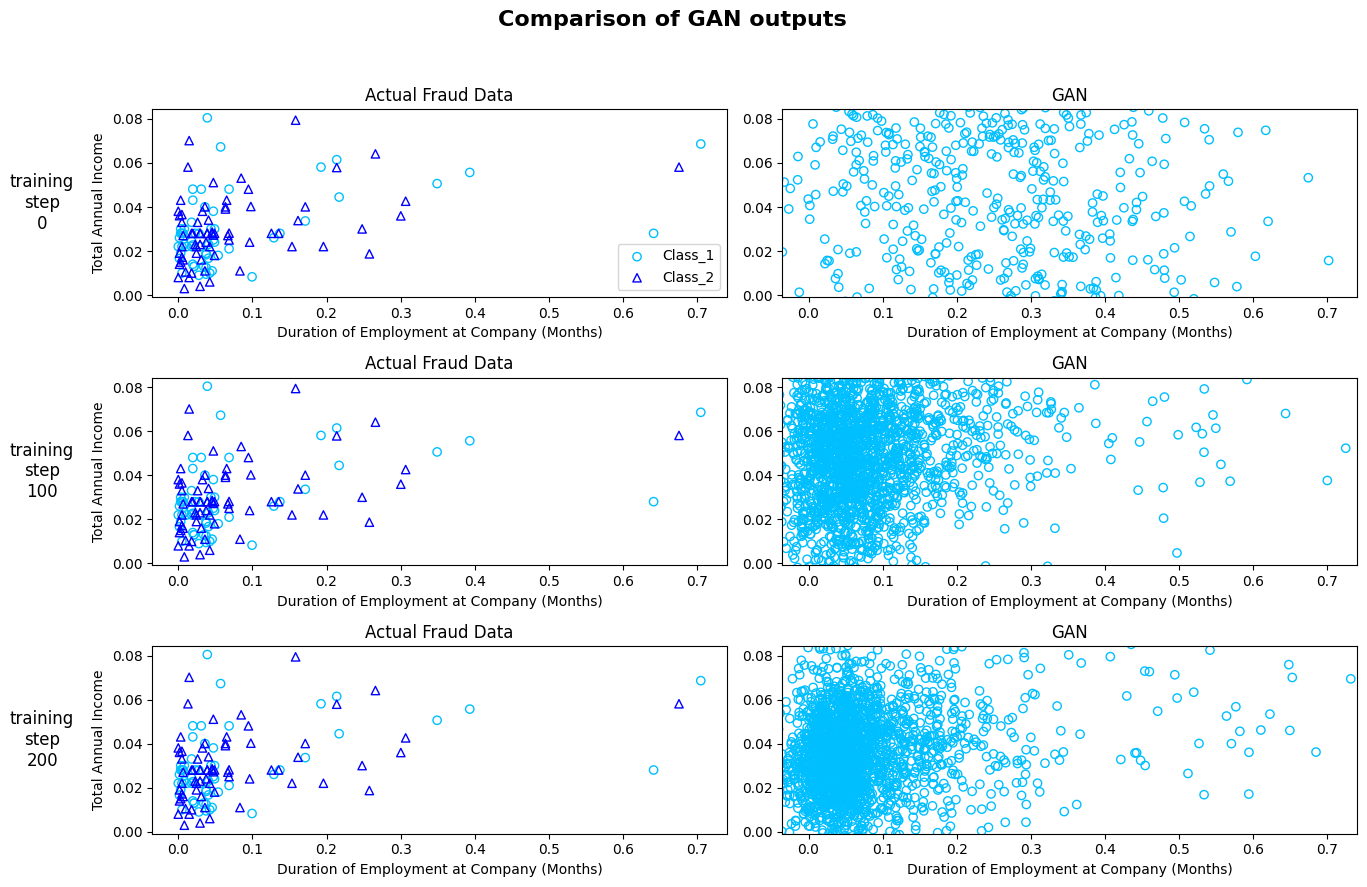

In [26]:
# Setup parameters visualization parameters
seed = 17
test_size = 2000 # number of fraud cases
noise_dim = 293 ###############

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real_processed = synthesizer.processor.transform(fraud_w_classes)
real_samples = synthesizer.get_data_batch(real_processed, batch_size)
class_labels = ['Class_1','Class_2']
real_samples = pd.DataFrame(real_samples, columns=num_cols+class_labels)
labels = fraud_w_classes['Default 12 Flag']

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']

col1, col2 = 'Duration of Employment at Company (Months)', 'Total Annual Income'

base_dir = 'cache/'

# Actual fraud data visualization
model_steps = [ 0, 100, 200]
rows = len(model_steps)
columns = 1 + len(models)

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

# Go through each of the 3 model_step values -> 0, 100, 200
for model_step_ix, model_step in enumerate(model_steps):
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)

    # Plot 'Class 1' and 'Class 2' samples taken from the original data, in a random shuffled fashion
    for group, color, marker, label in zip(real_samples.groupby('Class_1'), colors, markers, class_labels ):
        plt.scatter( group[1][[col1]], group[1][[col2]],
                         label=label, marker=marker, edgecolors=color, facecolors='none' )

    plt.title('Actual Fraud Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()

    if model_step_ix == 0:
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')

    # Go through all the GAN models listed in 'model_names' and defined in 'models'
    for i, model_name in enumerate( model_names[:] ):

        [model_name, with_class, generator_model] = models[model_name]

        generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

        if with_class:
            g_z = generator_model([z, labels])
            gen_samples = pd.DataFrame(g_z, columns=num_cols+class_labels)
            for group, color, marker, label in zip( gen_samples.groupby('Class_1'), colors, markers, class_labels ):
                plt.scatter( group[1][[col1]], group[1][[col2]],
                                 label=label, marker=marker, edgecolors=color, facecolors='none' )
        else:
            g_z = generator_model(z)
            gen_samples = pd.DataFrame(g_z, columns=num_cols+class_labels)
            gen_samples.to_csv('Generated_sample.csv')
            #write_csv(gen_samples, 'Generated_sample.csv')
            plt.scatter( gen_samples[[col1]], gen_samples[[col2]],
                             label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)
        plt.xlabel(col1)
        ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for training steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

if not os.path.exists("./img"):
    os.makedirs("./img")
plt.savefig('img/Comparison_of_GAN_outputs.png', dpi=100)

### Training a HistGradientBoosting Classifier for the trainData combined with synthetic positives

In [ ]:
!pip install lightgbm catboost

  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
  Using cached plotly-6.5.0-py3-none-any.whl.metadata (8.5 kB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)
   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.8/102.5 MB 5.6 MB/s eta 0:00:19
    --------------------------------------- 1.8/102.5 MB 5.9 MB/s eta 0:00:17
   - -------------------------------------- 3.1/102.5 MB 6.4 MB/s eta 0:00:16
   - -------------------------------------- 3.1/102.5 MB 6.4 MB/s eta 0:00:16
   - -------------------------------------- 4.2/102.5 MB 4.4 MB/s eta 0:00:23
   - -------------------------------------- 4.5/102.5 MB 3.8 MB/s eta 0:00:26
   -- ------------------------------------- 5.2/102.5 MB 4.1 MB/s eta 0:00:24
   -- ------------------------------------- 6.3/102.5 MB 4.0 MB/s eta 0:00:25
   -- ------------------------------------- 6.3/1

In [52]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import joblib
import warnings
warnings.filterwarnings("ignore")

### Pipeline to process Data

In [53]:

# ---------- Robust OneHotEncoder constructor (supports different sklearn versions) ----------
def make_ohe(**kwargs):
    try:
        return OneHotEncoder(**kwargs)
    except TypeError:
        # older sklearn uses 'sparse' instead of 'sparse_output'
        if 'sparse_output' in kwargs:
            kwargs['sparse'] = kwargs.pop('sparse_output')
        return OneHotEncoder(**kwargs)

# ---------- Age transformer (same idea as used before) ----------
class AgeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, dob_col='Date of Birth', app_col='Application Date', out_col='Age', max_age=120):
        self.dob_col = dob_col
        self.app_col = app_col
        self.out_col = out_col
        self.max_age = max_age
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        # Ensure we have a DataFrame
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # Safely obtain the date-like series; if absent create NaT series
        app_series = X.get(self.app_col)
        dob_series = X.get(self.dob_col)

        if app_series is None:
            app_dt = pd.Series(pd.NaT, index=X.index)
        else:
            app_dt = pd.to_datetime(app_series, errors='coerce')

        if dob_series is None:
            dob_dt = pd.Series(pd.NaT, index=X.index)
        else:
            dob_dt = pd.to_datetime(dob_series, errors='coerce')

        # Compute difference safely; result may be Timedelta or all NaT
        diff = app_dt - dob_dt
        if hasattr(diff, 'dt'):
            age_series = (diff.dt.days / 365.25).astype(float)
        else:
            age_series = pd.Series(np.nan, index=X.index)

        X[self.out_col] = age_series
        # discard invalid ages
        X.loc[(X[self.out_col] < 0) | (X[self.out_col] > self.max_age), self.out_col] = np.nan
        X[f'{self.out_col}_missing'] = X[self.out_col].isna().astype(int)

        # drop original date columns if present
        for c in (self.dob_col, self.app_col):
            if c in X.columns:
                X.drop(columns=c, inplace=True)
        return X

# ---------- Data references (must exist in the notebook) ----------
# trainData : original training DataFrame (must have label 'Default 12 Flag' and 'ID')
# fraud_w_classes : generated dataset (should have same columns, including 'Default 12 Flag')
# testData : test DataFrame to predict on
# sample_submission.csv is used to preserve output format

# Basic checks
assert 'trainData' in globals(), "trainData not found in notebook"
assert 'synthetic_fraud' in globals(), "synthetic_fraud (synthetic) not found in notebook"
assert 'testData' in globals(), "testData not found in notebook"

train_df = trainData.copy()
synthetic_df = synthetic_fraud.copy()
test_df = testData.copy()

label_col = 'Default 12 Flag'

# for all data in synthetic_fraud set the label as 1
synthetic_df[label_col] = 1

synth_pos = synthetic_df.copy()

# Combine: original train + synthetic positives
combined = pd.concat([train_df, synth_pos], ignore_index=True)
print("Combined shape (train + synthetic positives):", combined.shape)
print("Class distribution after combining:\n", combined[label_col].value_counts())


Combined shape (train + synthetic positives): (130048, 315)
Class distribution after combining:
 Default 12 Flag
0.0    72069
1.0    57979
Name: count, dtype: int64


In [54]:

# ---------- Columns: try to reuse user-defined lists else infer ----------
try:
    numeric_cols = numericalCol[:]  # copy if defined earlier
except NameError:
    numeric_cols = combined.select_dtypes(include=[np.number]).columns.tolist()
    for c in ['ID', label_col]:
        if c in numeric_cols:
            numeric_cols.remove(c)

try:
    categorical_cols = categoricalCol[:]  # copy if defined earlier
except NameError:
    categorical_cols = [c for c in combined.columns if c not in numeric_cols + ['ID', label_col] and combined[c].dtype == 'object']

# Ensure 'Age' is present as a numeric feature after AgeTransformer runs
if 'Age' not in numeric_cols:
    numeric_cols = numeric_cols + ['Age']

print("Using numeric cols (sample):", numeric_cols[:8])
print("Using categorical cols (sample):", categorical_cols[:8])

# ---------- Preprocessing pipelines ----------
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ohe = make_ohe(handle_unknown='ignore', sparse_output=False)   # set sparse_output=True for sparse result if needed
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', ohe)
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
], remainder='drop')

# ---------- Full pipeline: Age -> preprocess -> Ensemble (LGBM, XGB, CatBoost) ----------
# Define base learners (simple default params; tune as needed)
lgb = LGBMClassifier(n_estimators=200, random_state=0)
hgb = HistGradientBoostingClassifier(max_iter=100, random_state=0)
cat = CatBoostClassifier(verbose=0, iterations=200, random_state=0)

# Soft voting ensemble to combine probabilities from the three learners
voting = VotingClassifier(estimators=[('lgb', lgb), ('hgb', hgb), ('cat', cat)], voting='soft', n_jobs=-1)

pipeline = Pipeline([
    ('age', AgeTransformer()),   # creates Age and Age_missing, drops original dates
    ('preproc', preprocessor),
    ('clf', voting)
])


Using numeric cols (sample): ['Declared Amount of Unsecured Loans', 'Number of Unsecured Loans', 'Number of Dependents', 'Number of Dependent Children', 'Rent Burden Amount', 'Duration of Residence (Months)', 'Duration of Employment at Company (Months)', 'Total Annual Income']
Using categorical cols (sample): ['Major Media Code', 'Internet Details', 'Reception Type Category', 'Gender', 'Single/Married Status', 'Residence Type', 'Name Type', 'Family Composition Type']


In [55]:
print(synth_pos.shape)
for col in synth_pos.columns:
    print(f"{col}: {synth_pos[col].dtype}")

(50048, 295)
Number of Dependents: float64
Number of Dependent Children: float64
JIS Address Code: float64
Rent Burden Amount: float64
Duration of Residence (Months): float64
Duration of Employment at Company (Months): float64
Total Annual Income: float64
Declared Number of Unsecured Loans: float64
Declared Amount of Unsecured Loans: float64
Number of Unsecured Loans: float64
Amount of Unsecured Loans: float64
Application Limit Amount(Desired): float64
Default 12 Flag: int64
Age: float64
is_weekend: int32
Application_Month: int32
Debt_to_Income: float64
Loan_Count_per_Dependent: float64
Rent_to_Income: float64
Loan_Amount_per_Income: float64
Declared_Loan_Amount_Diff: float64
Declared_Loan_Count_Diff: float64
Desired_Credit_to_Income: float64
Employment_Tenure_to_Age: float64
Children_to_Dependent_Ratio: float64
Household_Size: float64
Income_per_Month_Employment: float64
Major Media Code_1: float64
Major Media Code_2: float64
Major Media Code_3: float64
Major Media Code_5: float64
Maj

### Cross Validation

In [56]:

# ---------- Prepare X, y ----------
X_comb = combined.drop(columns=[label_col])
y_comb = combined[label_col].astype(int)

# Optional: quick CV to sanity-check (Stratified 5-fold ROC AUC)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
print("Running 5-fold CV (ROC AUC) on combined data (this may take a while)...")
cv_scores = cross_val_score(pipeline, X_comb, y_comb, cv=cv, scoring='roc_auc', n_jobs=-1)
print("CV ROC AUC scores:", np.round(cv_scores, 4))
print("Mean CV ROC AUC:", cv_scores.mean())


Running 5-fold CV (ROC AUC) on combined data (this may take a while)...
CV ROC AUC scores: [0.9538 0.953  0.9541 0.9541 0.9543]
Mean CV ROC AUC: 0.9538402219685359
CV ROC AUC scores: [0.9538 0.953  0.9541 0.9541 0.9543]
Mean CV ROC AUC: 0.9538402219685359


### Model Fitting

In [57]:
pipeline.fit(X_comb, y_comb)
# Save fitted ensemble voting pipeline
joblib.dump(pipeline, 'models/ensemble_voting.joblib')
print("Fitted ensemble voting pipeline saved to 'models/ensemble_voting.joblib'")

Fitted ensemble voting pipeline saved to 'models/ensemble_voting.joblib'


In [58]:
# ---------- Predict probabilities on test set ----------
# Prepare test X (drop label if present)
test_X = test_df.copy()
if label_col in test_X.columns:
    test_X = test_X.drop(columns=[label_col])

probs = pipeline.predict_proba(test_X)[:, 1]  # probability of class 1

# ---------- Prepare submission in same format as sample_submission.csv ----------
sample_sub = pd.read_csv('data/sample_submission.csv')
submission = sample_sub.copy()

# Assume second column is the probability column to fill
if submission.shape[1] >= 2:
    prob_col = submission.columns[1]
else:
    # fallback name
    prob_col = 'Probability'

submission[prob_col] = probs

# Align ID column if present in sample submission and test_df
id_col_sample = submission.columns[0]
if 'ID' in test_df.columns:
    submission[id_col_sample] = test_df['ID'].values
elif id_col_sample in test_df.columns:
    submission[id_col_sample] = test_df[id_col_sample].values
# else keep sample's ID column as-is (or numeric index)

submission.to_csv('my_submission.csv', index=False)
print("Wrote submission to 'my_submission.csv'. Preview:")
print(submission.head())

,

Wrote submission to 'my_submission.csv'. Preview:
             ID  Default 12 Flag
0  202511080001         0.045621
1  202511080002         0.052886
2  202511080003         0.064839
3  202511080004         0.032250
4  202511080005         0.081690


''

In [59]:
# Load saved ensemble and produce final submission
import joblib
import pandas as pd

# Load the saved pipeline
loaded = joblib.load('models/ensemble_voting.joblib')

# Prepare test set (same steps as earlier cells)
test_X = test_df.copy()
if 'Default 12 Flag' in test_X.columns:
    test_X = test_X.drop(columns=['Default 12 Flag'])

# Predict probabilities (class 1)
probs = loaded.predict_proba(test_X)[:, 1]

# Build submission using the sample_submission template
sample_sub = pd.read_csv('data/sample_submission.csv')
submission = sample_sub.copy()
if submission.shape[1] >= 2:
    prob_col = submission.columns[1]
else:
    prob_col = 'Probability'
submission[prob_col] = probs

# Align ID column if present
id_col_sample = submission.columns[0]
if 'ID' in test_df.columns:
    submission[id_col_sample] = test_df['ID'].values
elif id_col_sample in test_df.columns:
    submission[id_col_sample] = test_df[id_col_sample].values

# Write output
submission.to_csv('ensemble_submission.csv', index=False)
print("Wrote submission to 'ensemble_submission.csv'. Preview:")
print(submission.head())

Wrote submission to 'ensemble_submission.csv'. Preview:
             ID  Default 12 Flag
0  202511080001         0.045621
1  202511080002         0.052886
2  202511080003         0.064839
3  202511080004         0.032250
4  202511080005         0.081690
